# Supervised Learning - Assignment nº 2
## Loan Approval Prediction


### Description
The goal is to develop a machine learning model that predicts if a loan application is approved or not. 

The target variable is loan_status, a binary label where 1 indicates the loan is approved and 0 means it is not.

The dataset provided for training and testing was generated from a deep learning model trained on the Loan Approval Prediction dataset.

#### Files

- **train.csv**: Contains the training data, including the target variable loan_status.

- **test.csv**: Test data where the task is to predict the probability of loan approval (loan_status).

### Import libraries
Before running the notebook, make sure all the necessary libraries are installed.

This project includes a `requirements.txt` file that lists all dependencies.

To install them, run the following command in your terminal: ` pip install -r requirements.txt `

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Loading the Training Data

In [21]:
data = pd.read_csv('train.csv')

### Exploratory Data Analysis 

#### General infomation

In [22]:
print("Dataset info:")
print(data.info())
print("\n")

print("Status:")
print(data['loan_status'].unique())
print("\n")

print("First 5 rows of the dataset:")
print(data.head())
print("\n")

print("Summary statistics:")
print(data.describe())

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), in

#### Distribution of target variable


--- Distribution of target variable ---
loan_status
0   85.762
1   14.238
Name: proportion, dtype: float64


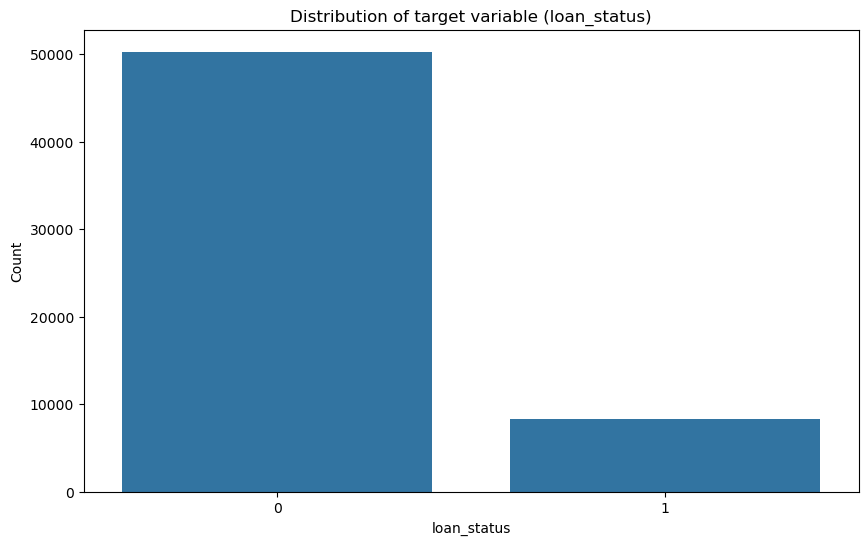

In [23]:
print("\n--- Distribution of target variable ---")
loan_status_counts = data['loan_status'].value_counts(normalize=True) * 100
print(loan_status_counts)

plt.figure(figsize=(10, 6))
sns.countplot(x='loan_status', data=data)
plt.title('Distribution of target variable (loan_status)')
plt.ylabel('Count')
plt.show()

### Data preprocessing 
#### Missing values

In [24]:
print("\n--- Missing values ---")
missing_values = data.isnull().sum()
print(missing_values)

print("\nRows containing missing values:")
print(data[data.isnull().any(axis=1)])


--- Missing values ---
id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

Rows containing missing values:
Empty DataFrame
Columns: [id, person_age, person_income, person_home_ownership, person_emp_length, loan_intent, loan_grade, loan_amnt, loan_int_rate, loan_percent_income, cb_person_default_on_file, cb_person_cred_hist_length, loan_status]
Index: []


#### 

#### Correlation of atributes

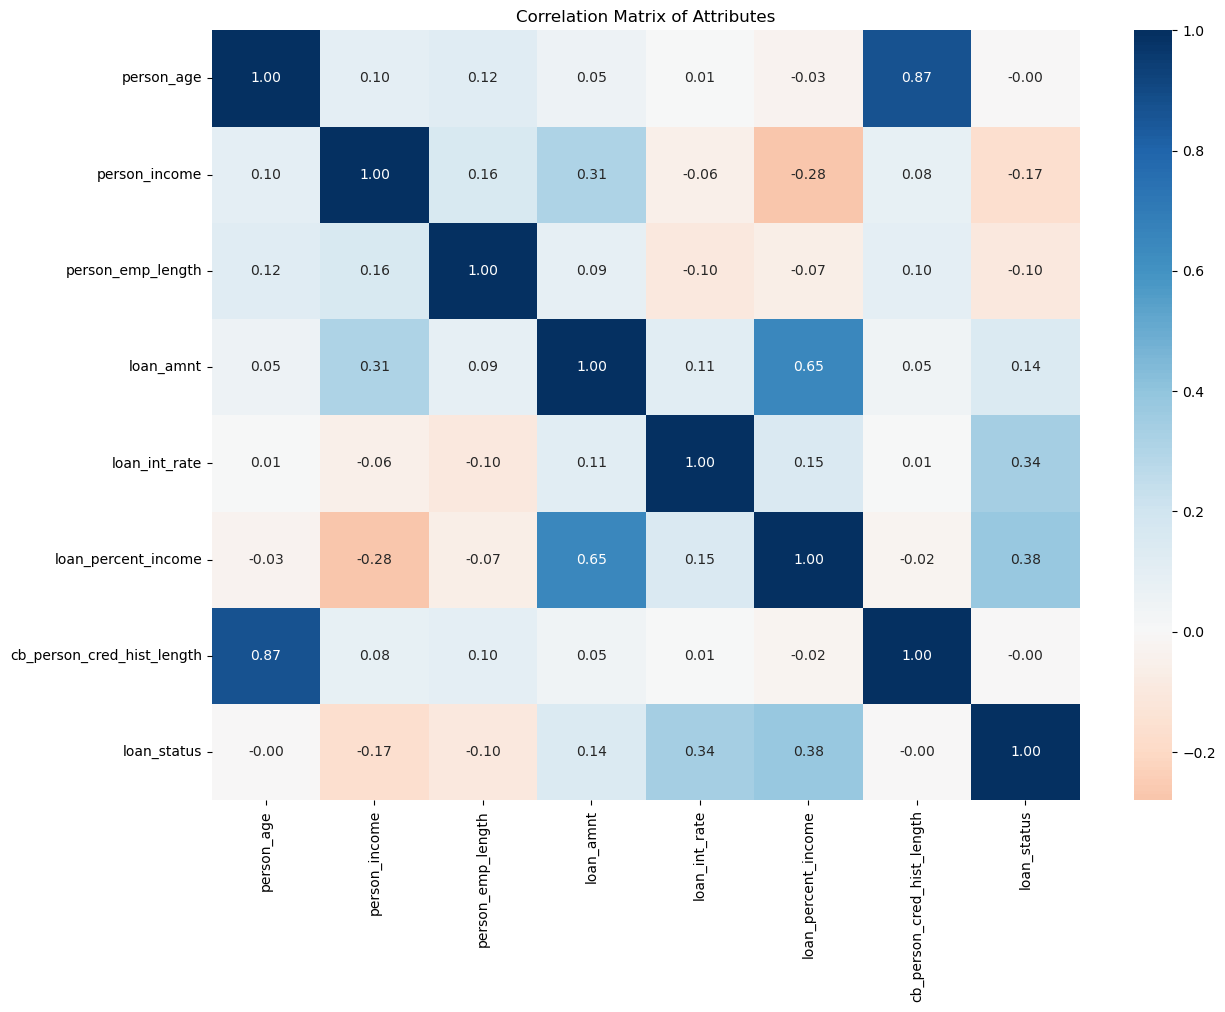

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data_encoded = pd.get_dummies(data.drop(columns=["id", "person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"]))

correlation_matrix = data_encoded.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdBu', center=0)
plt.title("Correlation Matrix of Attributes")
plt.show()

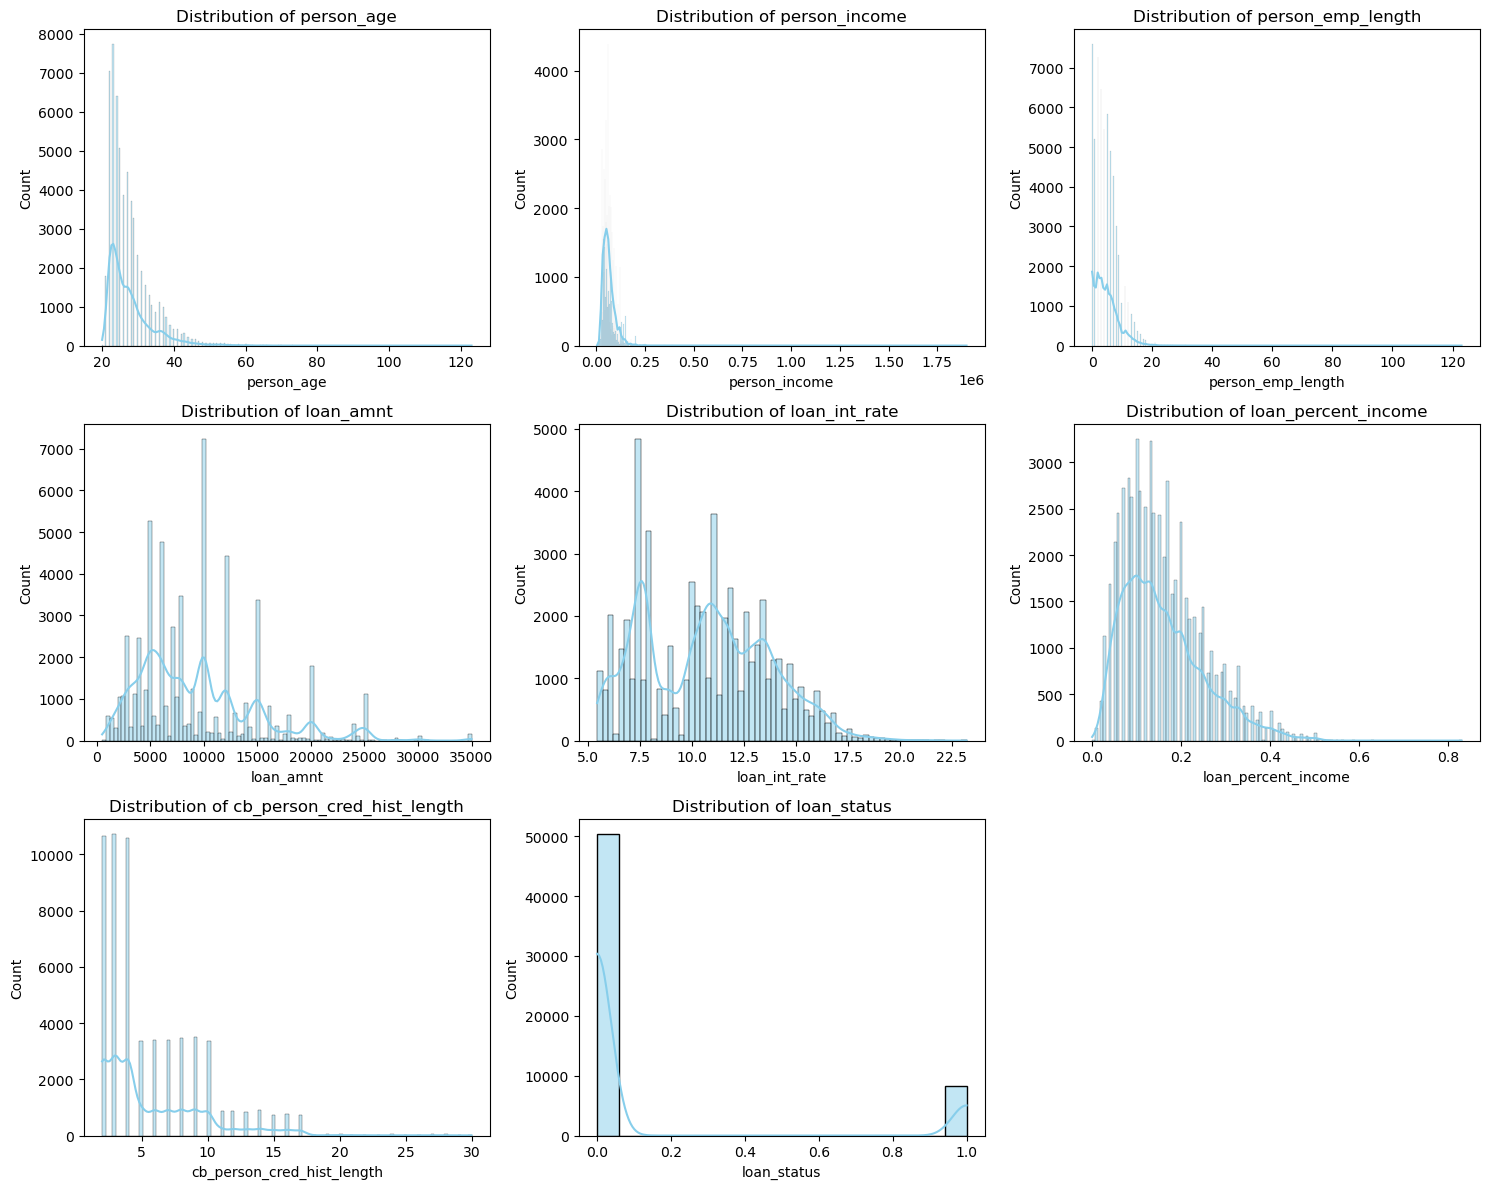

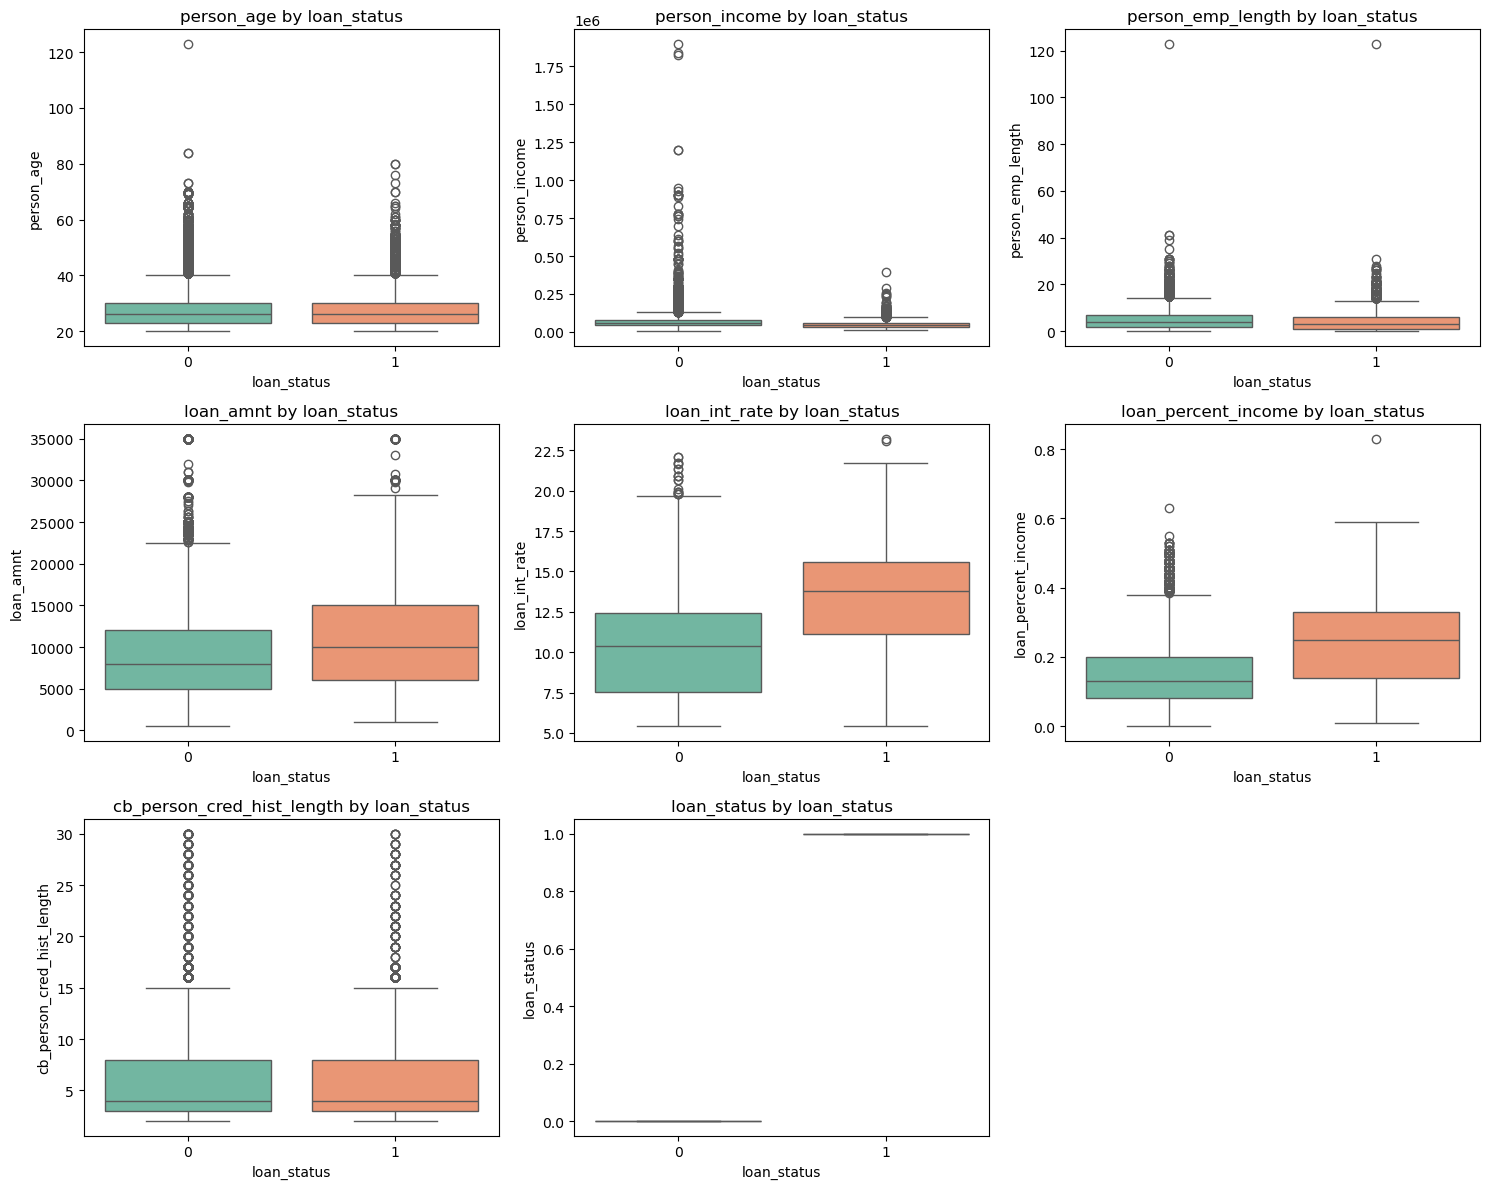

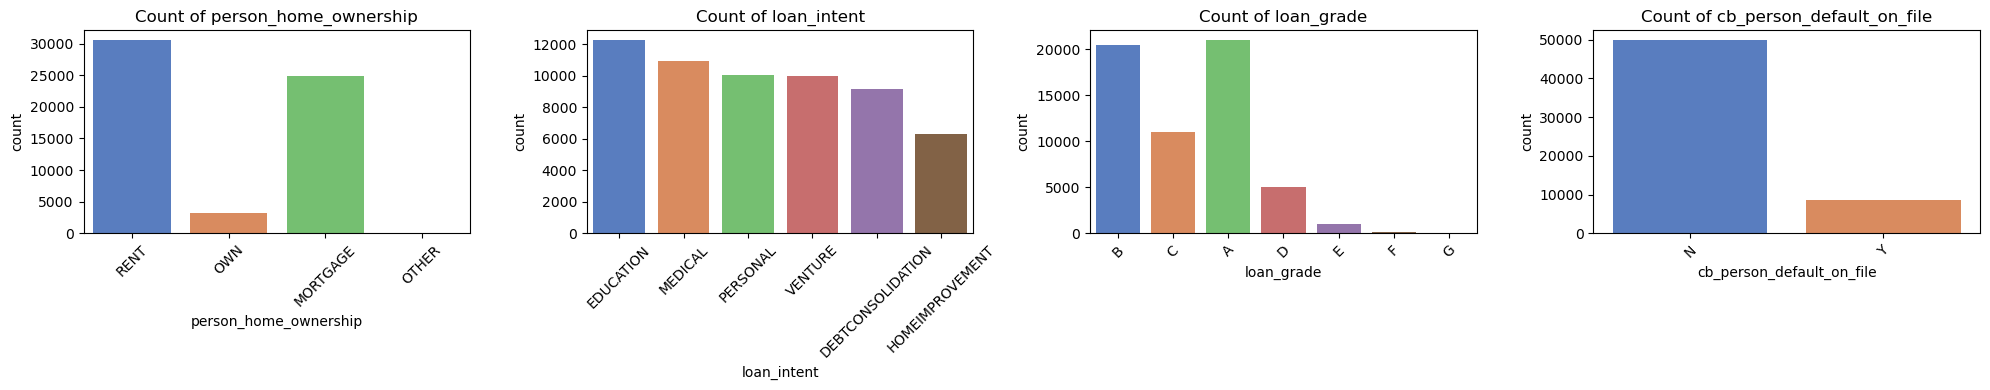

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_numeric_columns(data, numeric_cols, cols_per_row=3):
    rows = (len(numeric_cols) + cols_per_row - 1) // cols_per_row
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(5 * cols_per_row, 4 * rows))
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        sns.histplot(data[col], kde=True, ax=axes[i], color='skyblue')
        axes[i].set_title(f'Distribution of {col}')
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()


def plot_numeric_boxplots(data, numeric_cols, target_col, cols_per_row=3):
    rows = (len(numeric_cols) + cols_per_row - 1) // cols_per_row
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(5 * cols_per_row, 4 * rows))
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        sns.boxplot(x=target_col, y=col, data=data, ax=axes[i], hue=target_col, palette='Set2', legend=False)
        axes[i].set_title(f'{col} by {target_col}')
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()


def plot_categorical_columns(data, categorical_cols, cols_per_row=4):
    rows = (len(categorical_cols) + cols_per_row - 1) // cols_per_row
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(5 * cols_per_row, 4 * rows))
    axes = axes.flatten()

    for i, col in enumerate(categorical_cols):
        sns.countplot(x=col, hue=col, data=data, ax=axes[i], palette='muted', legend=False)
        axes[i].set_title(f'Count of {col}')
        axes[i].tick_params(axis='x', rotation=45)
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()


numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols.remove('id')  # Se não quiseres o 'id'
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()

# Plots
plot_numeric_columns(data, numeric_cols)
plot_numeric_boxplots(data, numeric_cols, target_col='loan_status')
plot_categorical_columns(data, categorical_cols)

In [27]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.3f}'.format)

def analyze_numeric_attribute(df, column_name):
    print(f"\n=== Analysis of {column_name} ===")
    stats = df[column_name].describe()
    print(stats)
    
    missing = df[column_name].isna().sum()
    missing_percent = (missing / len(df)) * 100
    print(f"\nMissing values: {missing} ({missing_percent:.2f}%)")
    
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((df[column_name] < lower_bound) | (df[column_name] > upper_bound)).sum()
    print(f"Outliers: {outliers} ({(outliers/len(df))*100:.2f}%)")
    
    print(f"Median: {df[column_name].median()}")
    print(f"Mode: {df[column_name].mode().values[0]}")
    print(f"Variance: {df[column_name].var()}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    sns.histplot(df[column_name], kde=True, ax=ax1)
    ax1.set_title(f'Distribution of {column_name}')
    
    sns.boxplot(x=df[column_name], ax=ax2)
    ax2.set_title(f'Box Plot of {column_name}')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='loan_status', y=column_name, data=df)
    plt.title(f'{column_name} by Loan Status')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def analyze_categorical_attribute(df, column_name):
    print(f"\n=== Analysis of {column_name} ===")
    
    plt.figure(figsize=(12, 6))
    sns.countplot(y=column_name, data=df, order=df[column_name].value_counts().index)
    plt.title(f'Distribution of {column_name}')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    crosstab = pd.crosstab(df[column_name], df['loan_status'], normalize='index') * 100
    crosstab.plot(kind='bar', stacked=False)
    plt.title(f'Percentage of Loan Status by {column_name}')
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.legend(title='loan_status')
    plt.tight_layout()
    plt.show()   


=== Analysis of person_age ===
count   58645.000
mean       27.551
std         6.033
min        20.000
25%        23.000
50%        26.000
75%        30.000
max       123.000
Name: person_age, dtype: float64

Missing values: 0 (0.00%)
Outliers: 2446 (4.17%)
Median: 26.0
Mode: 23
Variance: 36.39969254217382


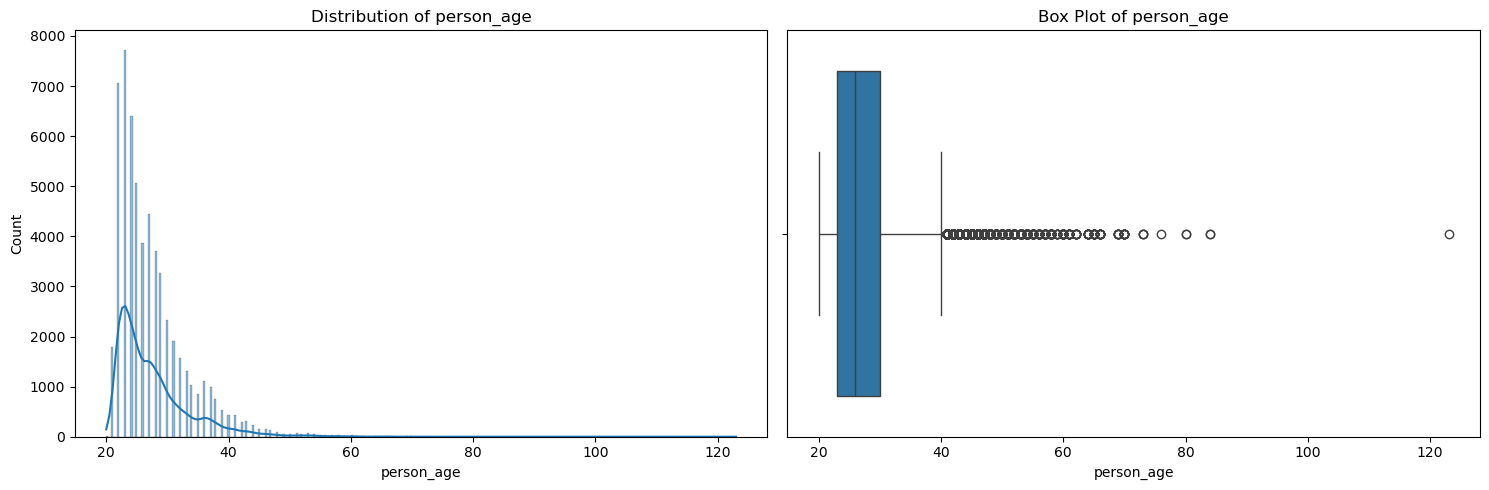

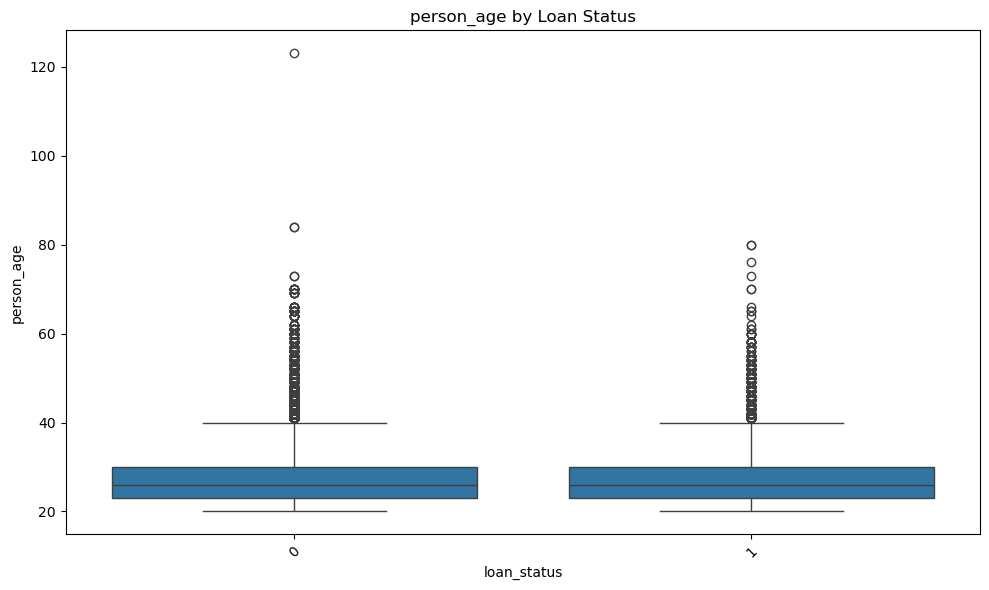


=== Analysis of person_income ===
count     58645.000
mean      64046.173
std       37931.107
min        4200.000
25%       42000.000
50%       58000.000
75%       75600.000
max     1900000.000
Name: person_income, dtype: float64

Missing values: 0 (0.00%)
Outliers: 2411 (4.11%)
Median: 58000.0
Mode: 60000
Variance: 1438768876.6144187


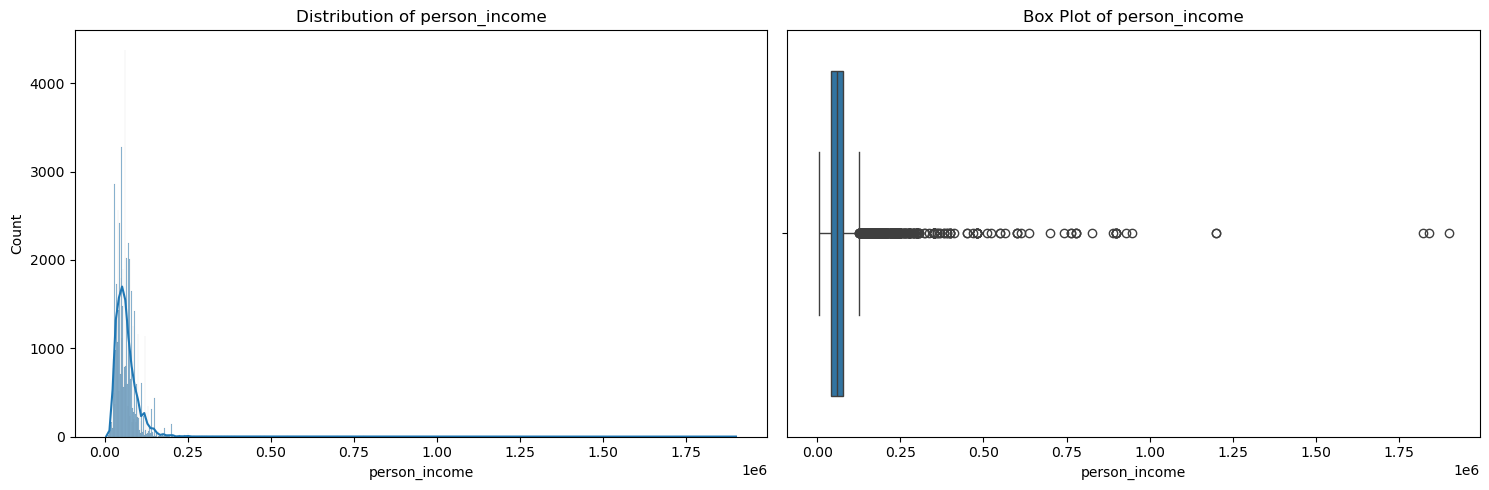

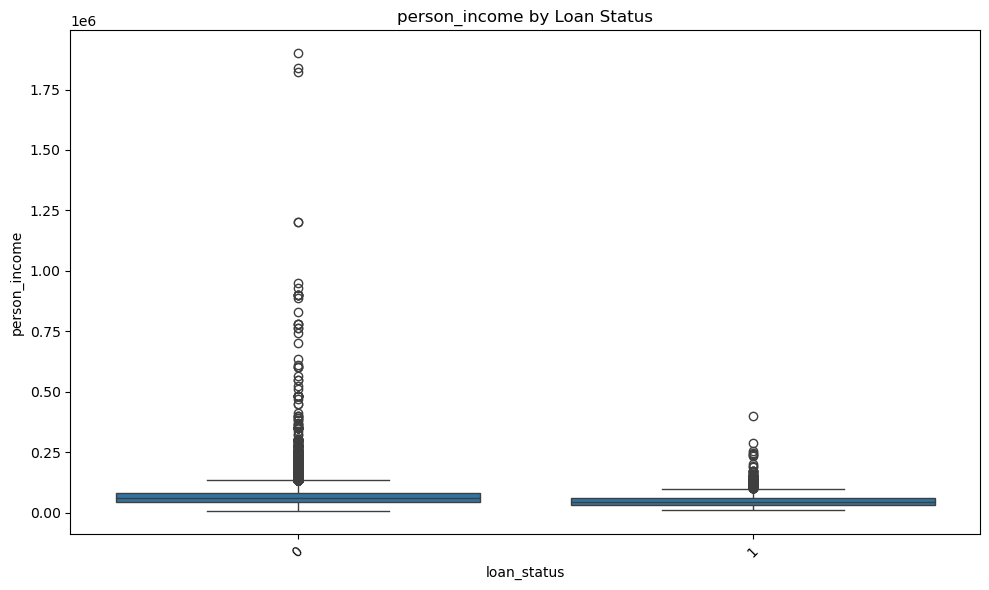


=== Analysis of person_emp_length ===
count   58645.000
mean        4.701
std         3.960
min         0.000
25%         2.000
50%         4.000
75%         7.000
max       123.000
Name: person_emp_length, dtype: float64

Missing values: 0 (0.00%)
Outliers: 1274 (2.17%)
Median: 4.0
Mode: 0.0
Variance: 15.679892054305258


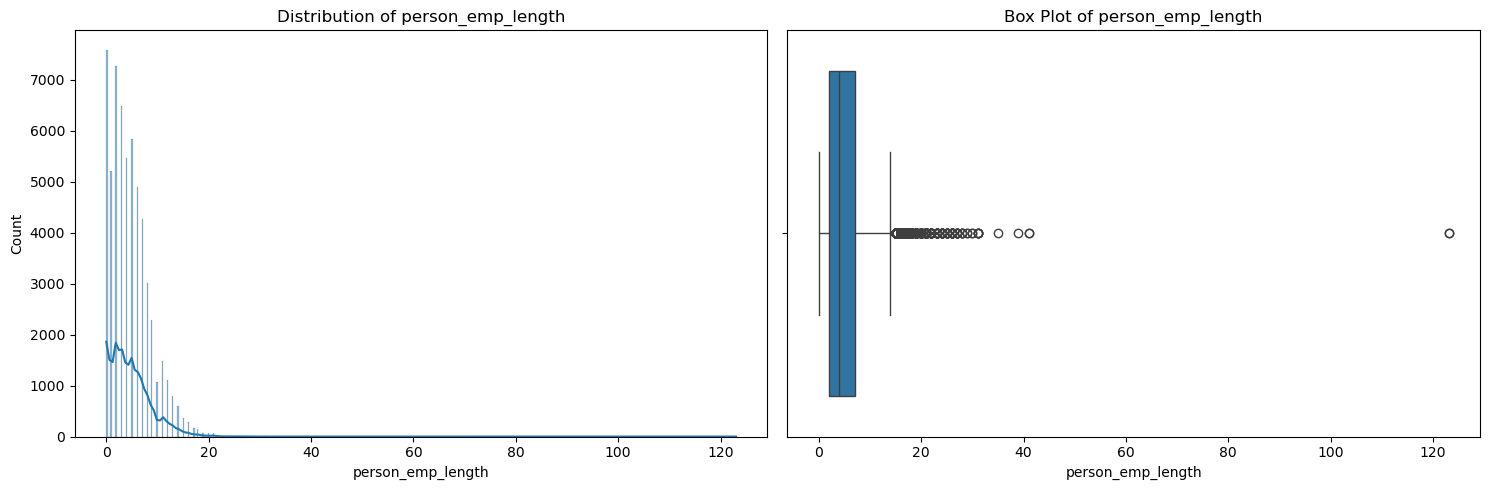

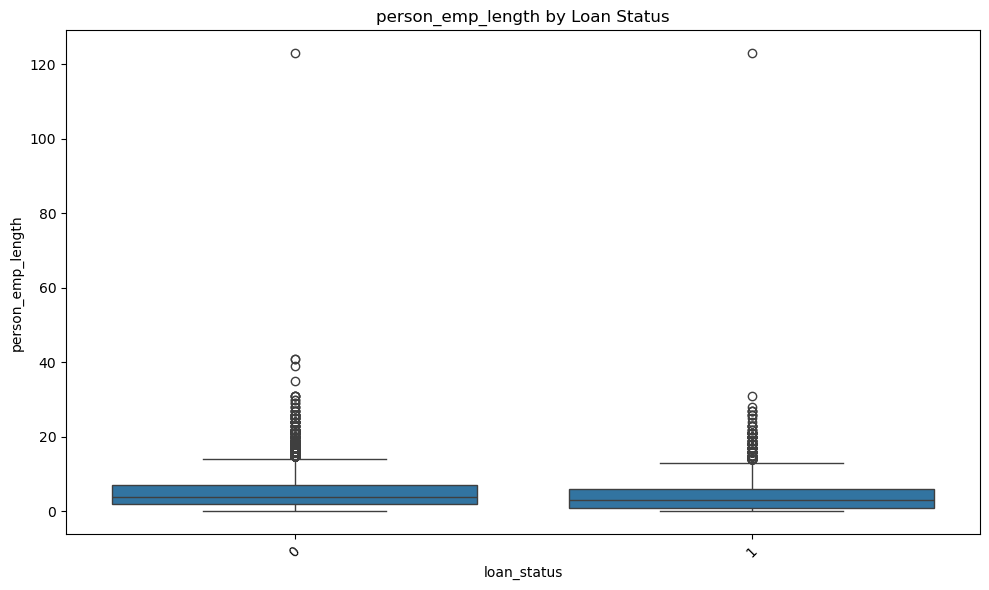


=== Analysis of loan_amnt ===
count   58645.000
mean     9217.557
std      5563.807
min       500.000
25%      5000.000
50%      8000.000
75%     12000.000
max     35000.000
Name: loan_amnt, dtype: float64

Missing values: 0 (0.00%)
Outliers: 2045 (3.49%)
Median: 8000.0
Mode: 10000
Variance: 30955952.6080763


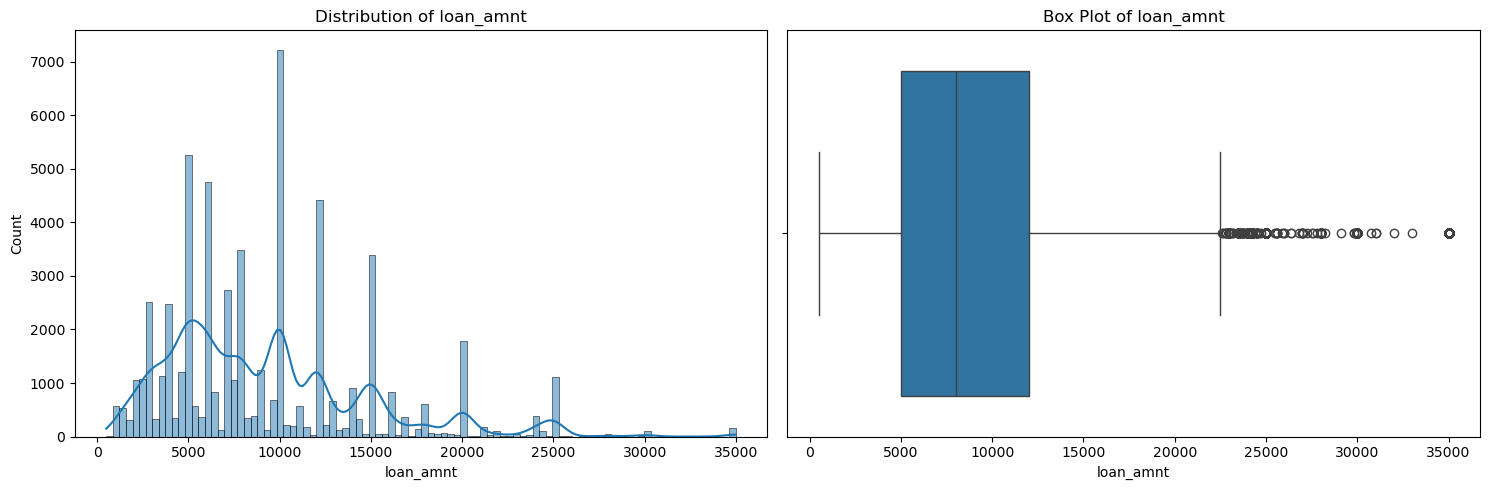

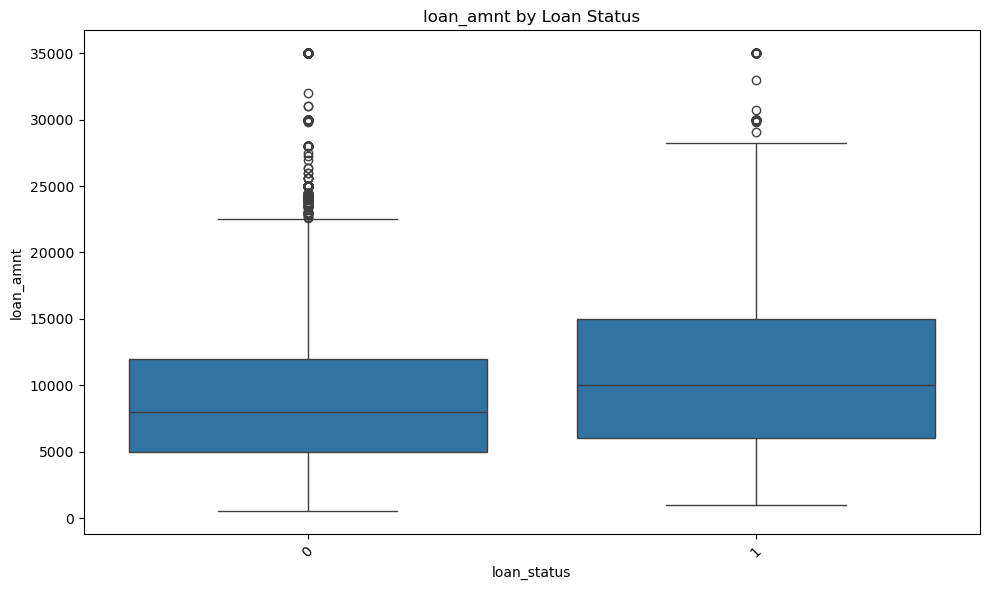


=== Analysis of loan_int_rate ===
count   58645.000
mean       10.678
std         3.035
min         5.420
25%         7.880
50%        10.750
75%        12.990
max        23.220
Name: loan_int_rate, dtype: float64

Missing values: 0 (0.00%)
Outliers: 34 (0.06%)
Median: 10.75
Mode: 10.99
Variance: 9.209387114731829


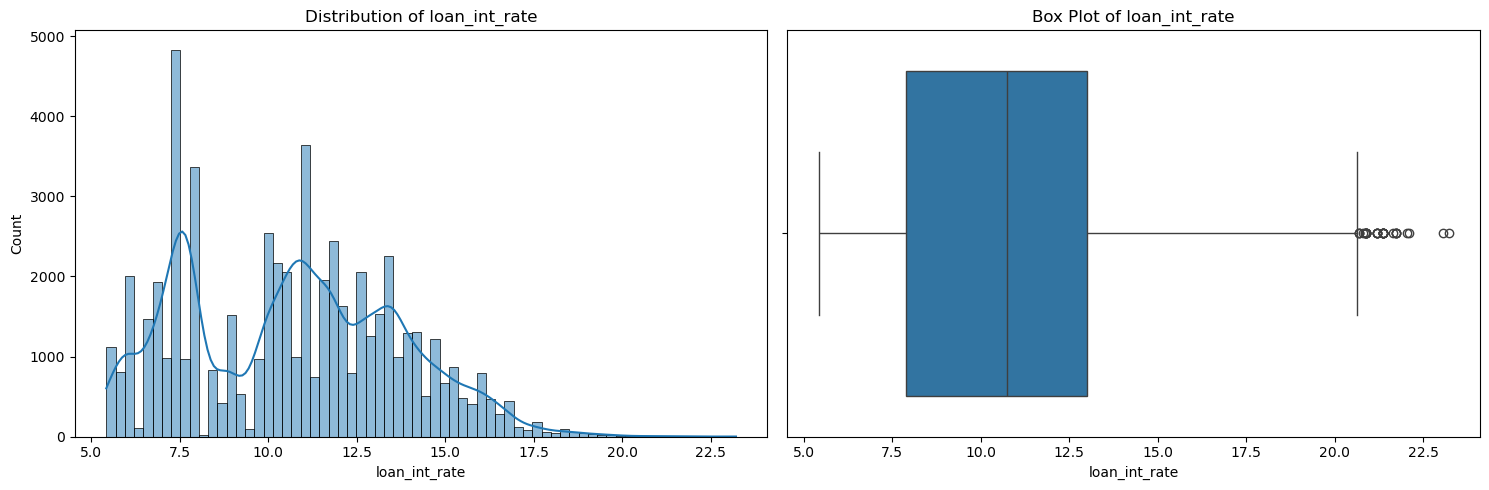

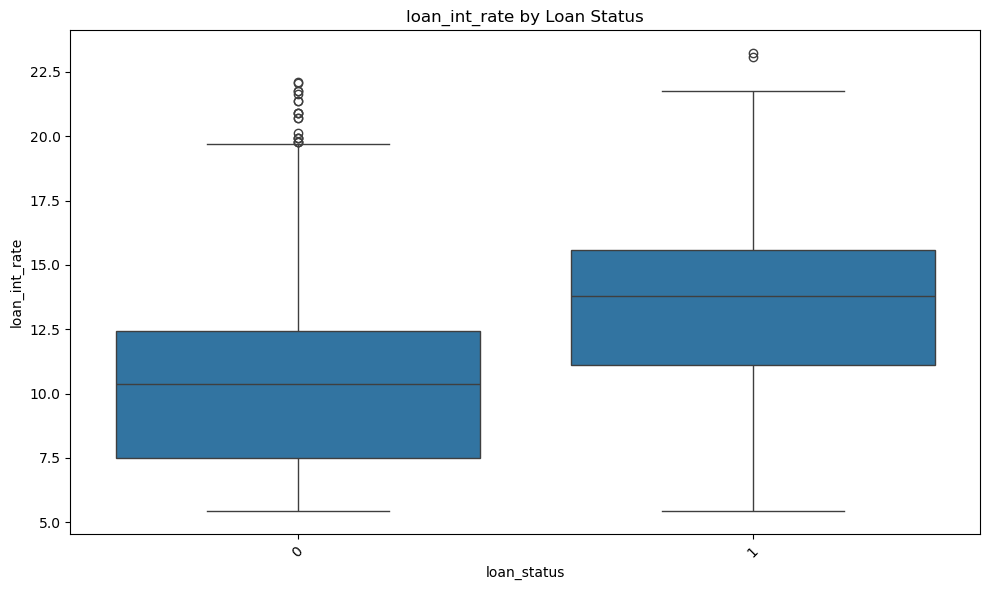


=== Analysis of loan_percent_income ===
count   58645.000
mean        0.159
std         0.092
min         0.000
25%         0.090
50%         0.140
75%         0.210
max         0.830
Name: loan_percent_income, dtype: float64

Missing values: 0 (0.00%)
Outliers: 1210 (2.06%)
Median: 0.14
Mode: 0.1
Variance: 0.008407384910127479


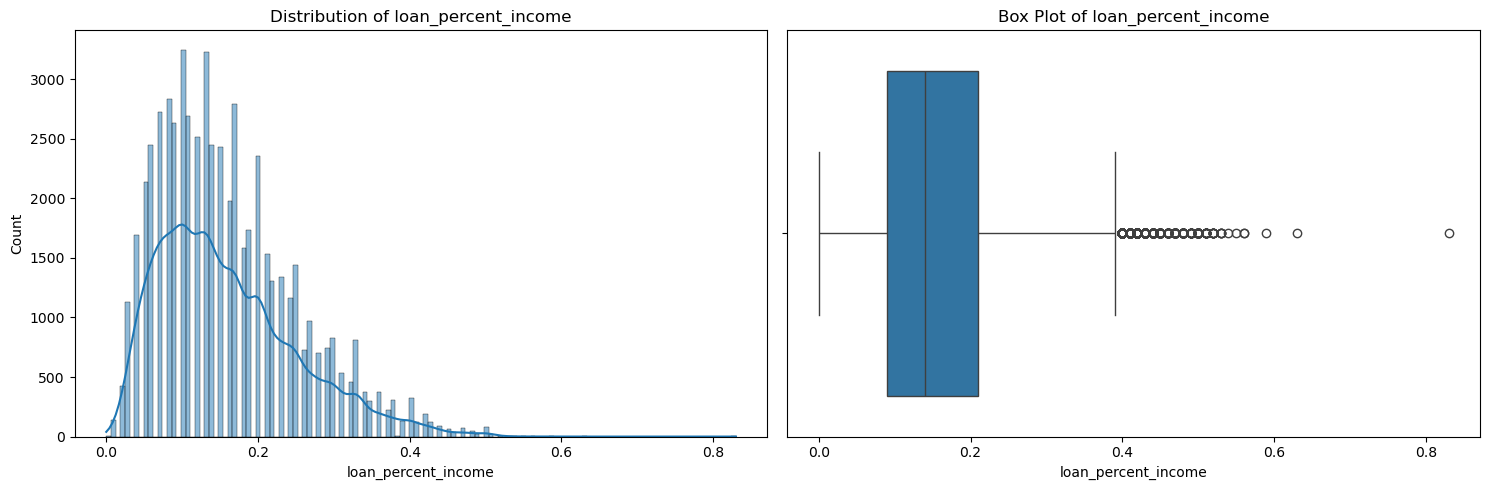

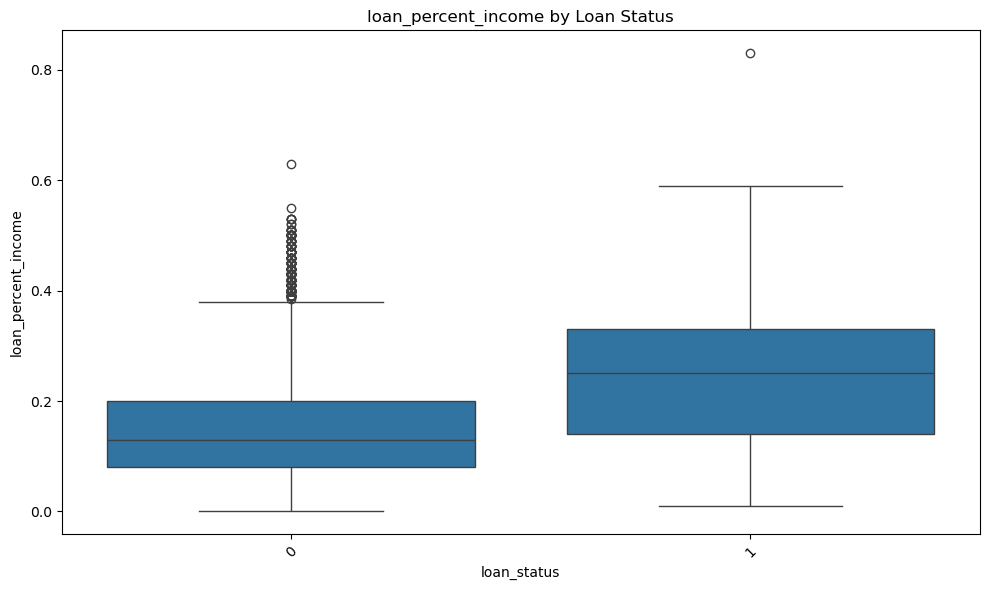


=== Analysis of cb_person_cred_hist_length ===
count   58645.000
mean        5.814
std         4.029
min         2.000
25%         3.000
50%         4.000
75%         8.000
max        30.000
Name: cb_person_cred_hist_length, dtype: float64

Missing values: 0 (0.00%)
Outliers: 1993 (3.40%)
Median: 4.0
Mode: 3
Variance: 16.23442164358244


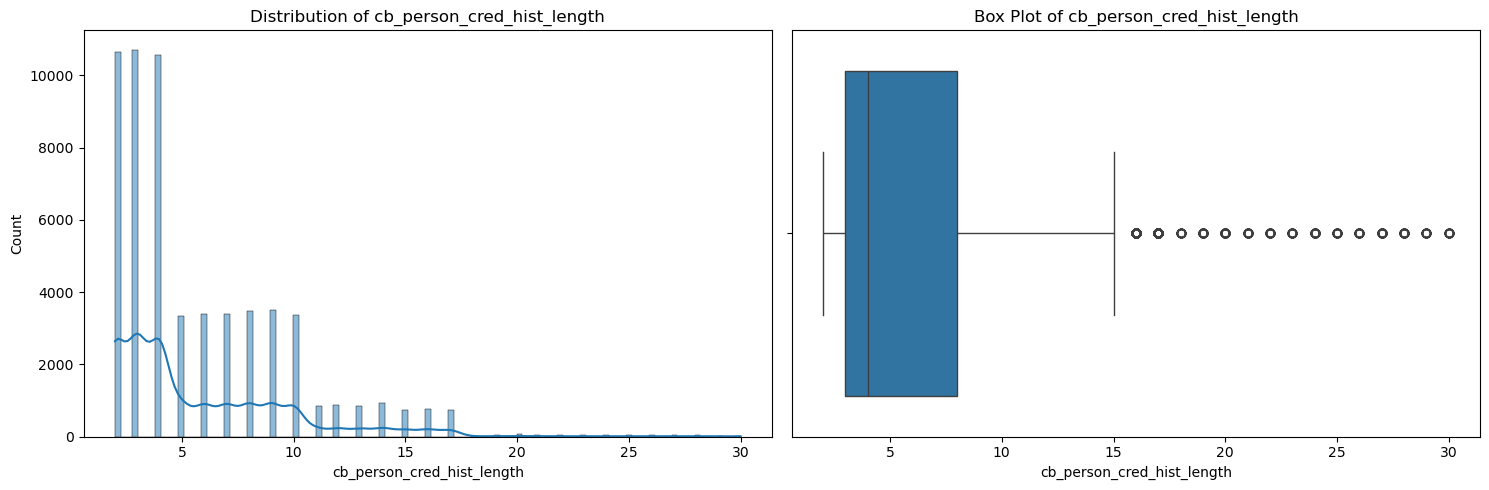

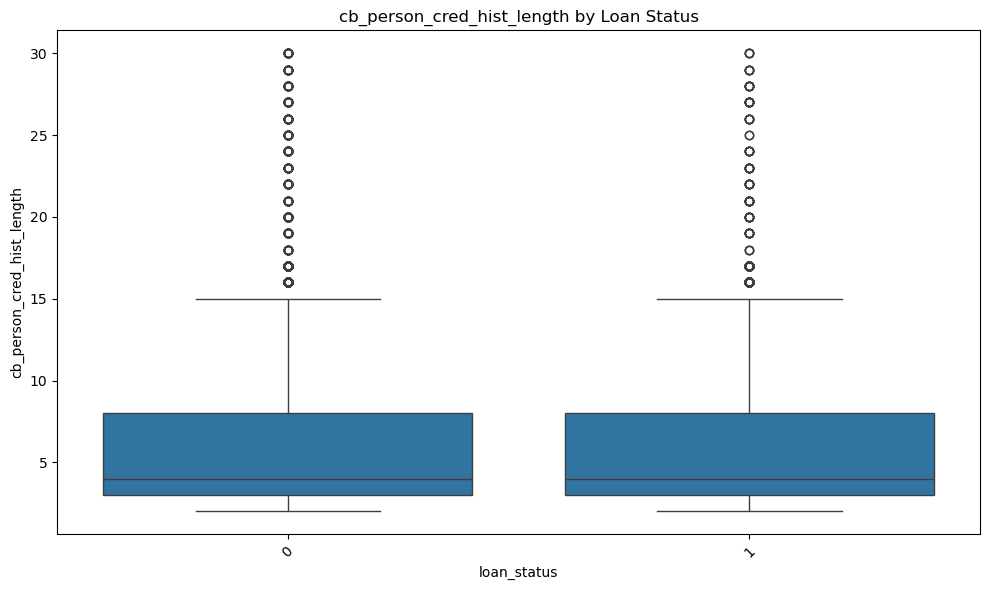


=== Analysis of person_home_ownership ===


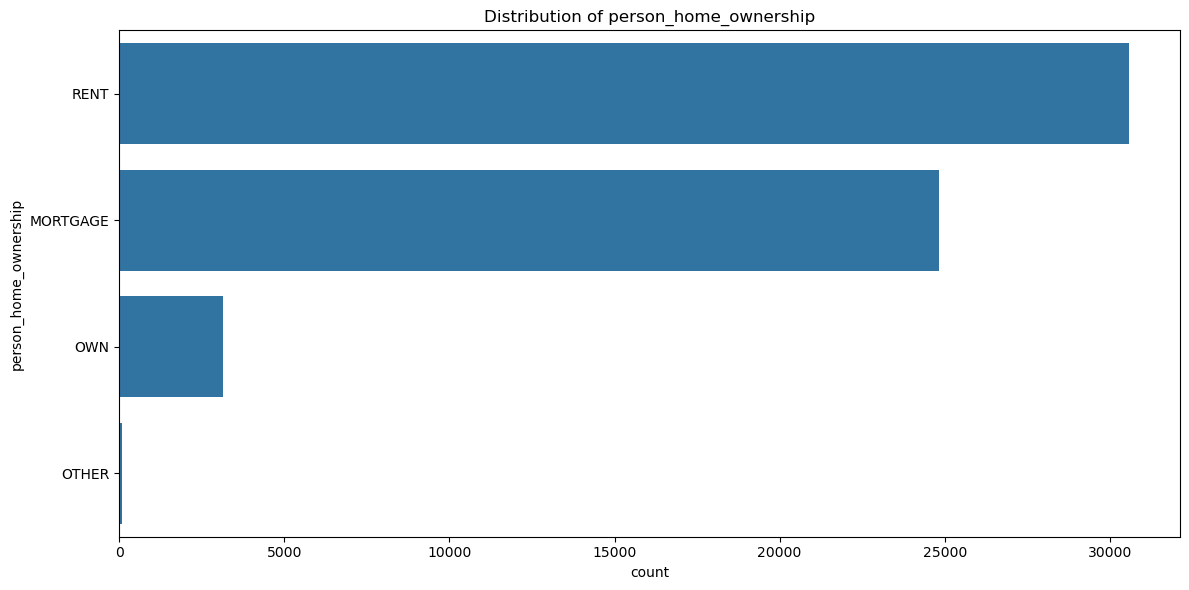

<Figure size 1200x600 with 0 Axes>

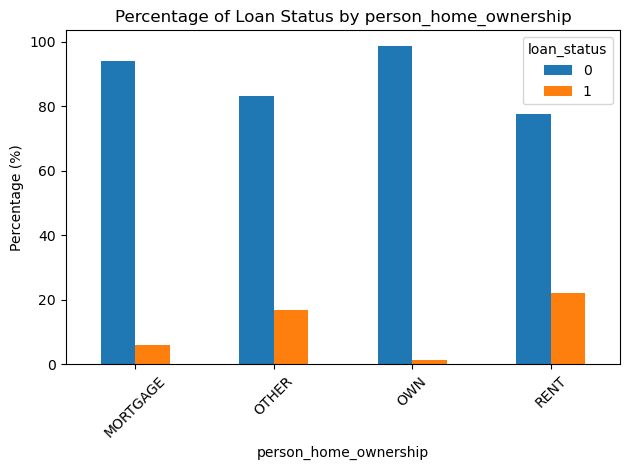


=== Analysis of loan_intent ===


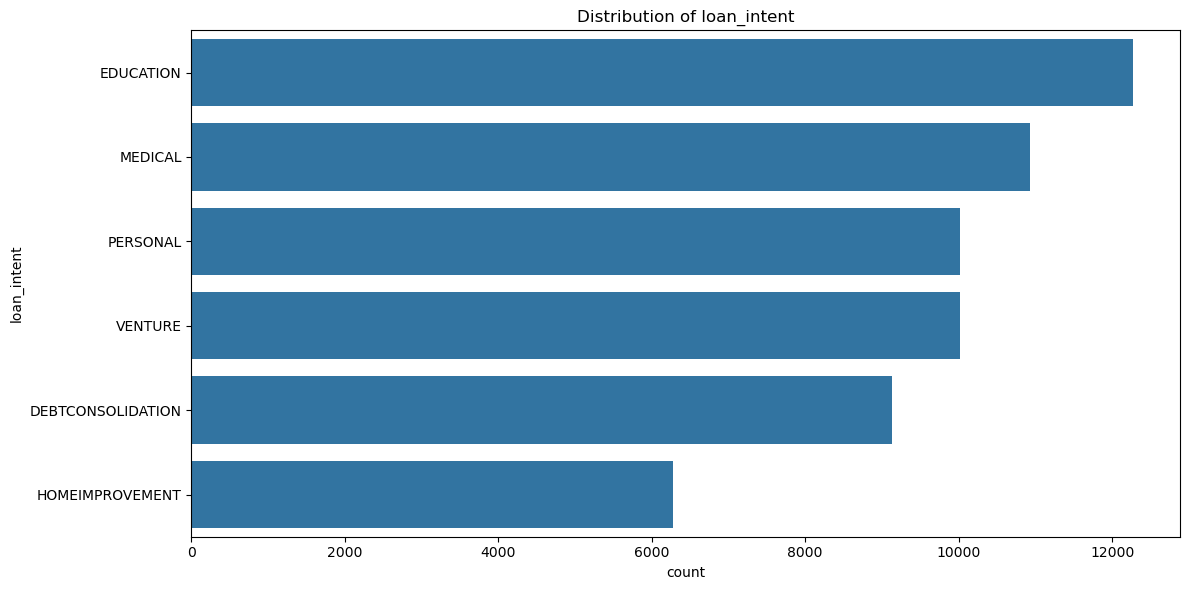

<Figure size 1200x600 with 0 Axes>

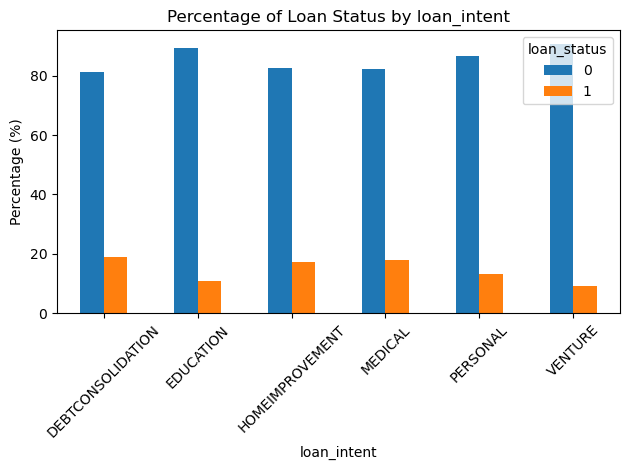


=== Analysis of loan_grade ===


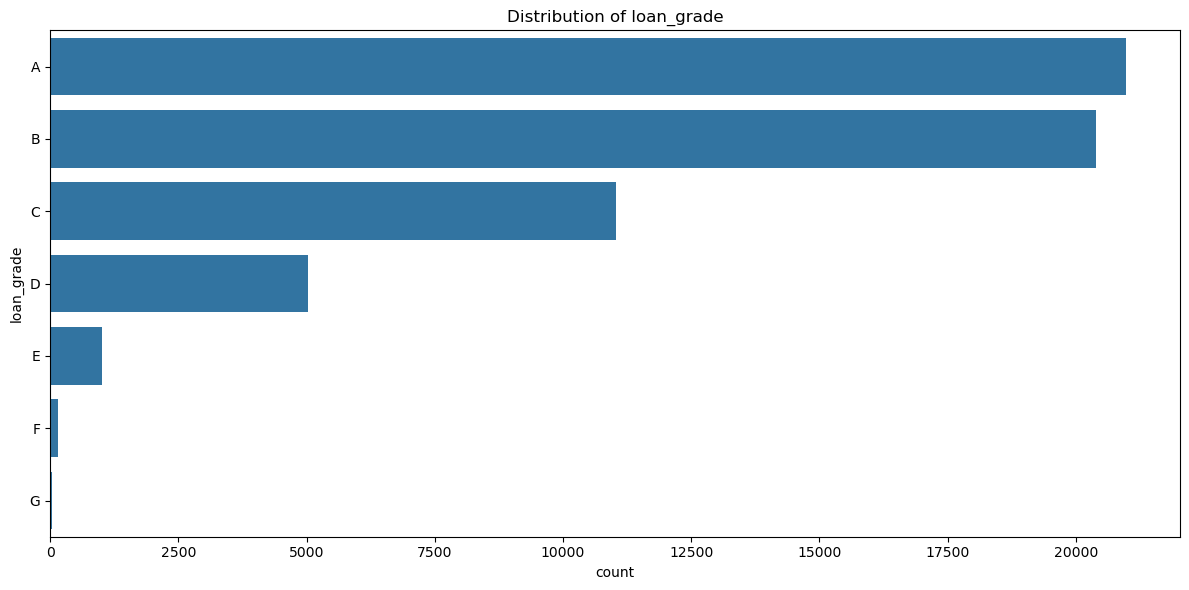

<Figure size 1200x600 with 0 Axes>

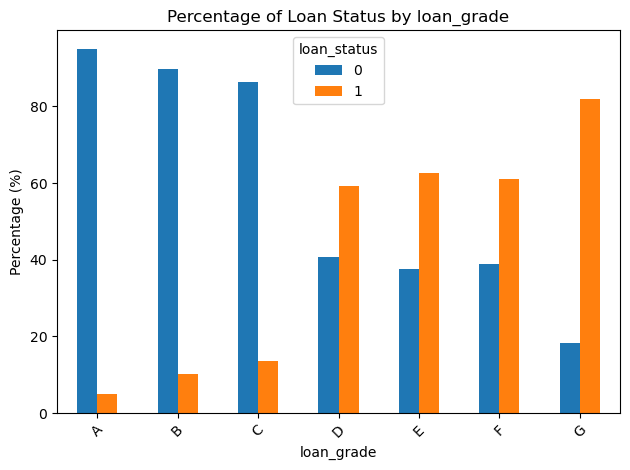


=== Analysis of cb_person_default_on_file ===


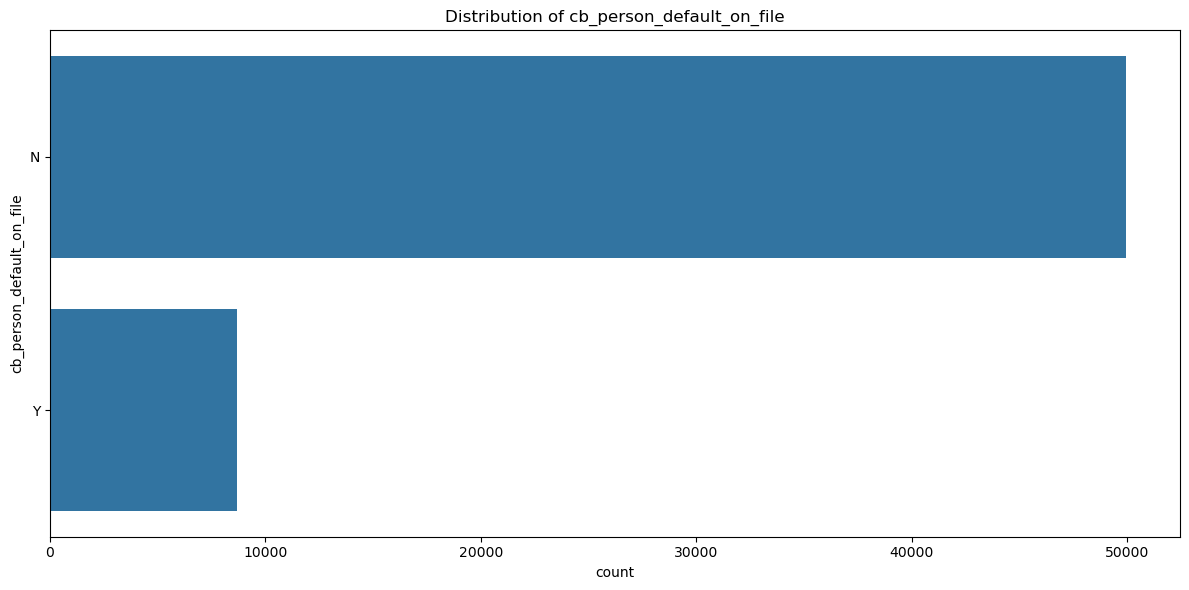

<Figure size 1200x600 with 0 Axes>

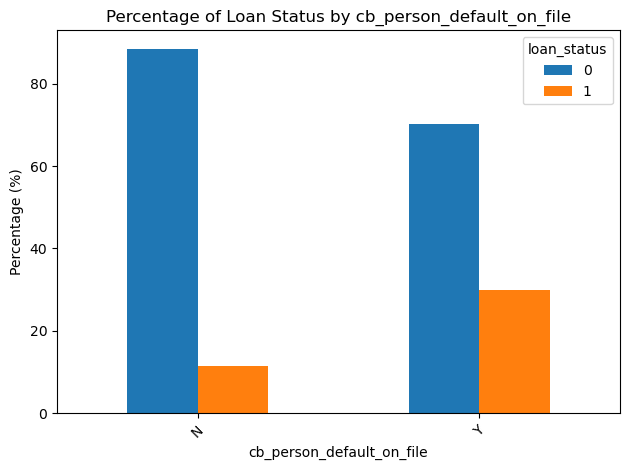

In [28]:
numeric_attributes = [
    'person_age', 'person_income', 'person_emp_length', 
    'loan_amnt', 'loan_int_rate', 'loan_percent_income', 
    'cb_person_cred_hist_length'
]

categorical_attributes = [
    'person_home_ownership', 'loan_intent', 'loan_grade',
    'cb_person_default_on_file'
]

for attr in numeric_attributes:
    if attr in data.columns:
        analyze_numeric_attribute(data, attr)

for attr in categorical_attributes:
    if attr in data.columns:
        analyze_categorical_attribute(data, attr)


### Supervised Learning Algorithms

#### Decision Tree

In [29]:
from sklearn.model_selection import train_test_split

data = pd.read_csv('train.csv')

# Convert categorical variables to numerical
data = pd.get_dummies(data, columns=["person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"])

# Convert boolean values to integers
data = data.astype({col: int for col in data.select_dtypes(include=['bool']).columns})

# Define inputs and labels
all_inputs = data.drop(columns=["loan_status", "id"]).values  # Drop 'loan_status' and 'id' from inputs
all_labels = data["loan_status"].values  # Use 'loan_status' as label

# Check the dtype of all_inputs
print(all_inputs.dtype)


float64


(array([ 1.,  2.,  8., 12., 24., 23., 17.,  8.,  3.,  2.]),
 array([0.90662938, 0.90792525, 0.90922112, 0.91051698, 0.91181285,
        0.91310872, 0.91440458, 0.91570045, 0.91699632, 0.91829218,
        0.91958805]),
 <BarContainer object of 10 artists>)

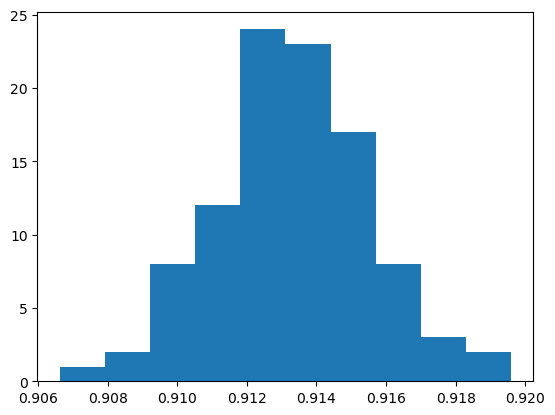

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

model_accuracies = []

for repetition in range(100):
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.25)
    
    decision_tree_classifier = DecisionTreeClassifier(random_state=1)

    # Train the classifier on the training set
    decision_tree_classifier.fit(training_inputs, training_classes)

    # Validate the classifier on the testing set
    predicted_classes = decision_tree_classifier.predict(testing_inputs)

    model_accuracies.append(accuracy_score(testing_classes, predicted_classes))

plt.hist(model_accuracies)

Try decision tree with k-fold

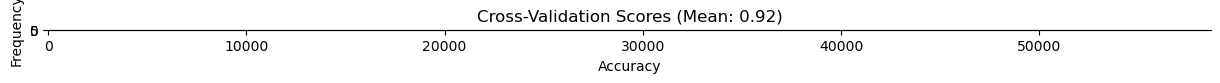

[0.91355499 0.91679454 0.92054561 0.91679454 0.91577153 0.92223738
 0.91456344 0.91678035 0.91251705 0.90876535]
Average accuracy across 10 folds: 0.92


In [31]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

def plot_cv(cv, features, labels):
    masks = []
    for train, test in cv.split(features, labels):
        mask = np.zeros(len(labels), dtype=bool)
        mask[test] = 1
        masks.append(mask)
    
    plt.figure(figsize=(15, 15))
    plt.imshow(masks, interpolation='none', cmap='gray_r')
    plt.ylabel('Fold')
    plt.xlabel('Row #')

plot_cv(StratifiedKFold(n_splits=10), all_inputs, all_labels)

from sklearn.model_selection import cross_val_score

decision_tree_classifier = DecisionTreeClassifier()

stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
cv_scores = cross_val_score(decision_tree_classifier, all_inputs, all_labels, cv=stratified_kfold)

plt.hist(cv_scores, bins=10, edgecolor='black')
plt.title(f'Cross-Validation Scores (Mean: {np.mean(cv_scores):.2f})')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

print(cv_scores)
print(f"Average accuracy across 10 folds: {np.mean(cv_scores):.2f}")

Find best performing parameters

Best score: 0.9457754047701291
Best parameters: {'max_depth': 9, 'max_features': 11}


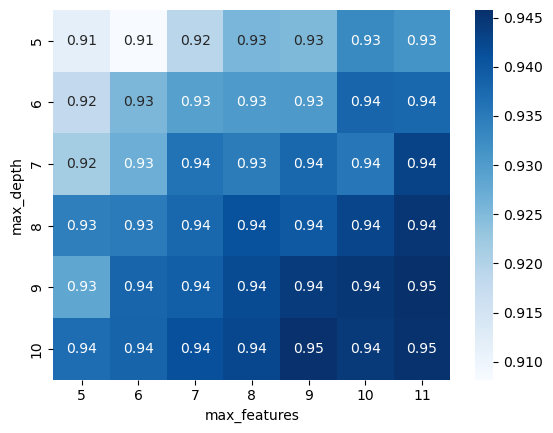

In [32]:
from sklearn.model_selection import GridSearchCV
import seaborn as sb
decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {
    'max_depth': [5, 6, 7, 8, 9, 10],
    'max_features': [5, 6, 7, 8, 9, 10, 11],
}

cross_validation = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
grid_search = GridSearchCV(
    estimator=decision_tree_classifier,
    param_grid=parameter_grid,
    cv=cross_validation,
    scoring='accuracy'
)
grid_search.fit(all_inputs, all_labels)

grid_visualization = grid_search.cv_results_['mean_test_score']
grid_visualization.shape = (len(parameter_grid['max_depth']), len(parameter_grid['max_features']))

sb.heatmap(grid_visualization, cmap='Blues', annot=True)
plt.xticks(np.arange(len(parameter_grid['max_features'])) + 0.5, parameter_grid['max_features'])
plt.yticks(np.arange(len(parameter_grid['max_depth'])) + 0.5, parameter_grid['max_depth'])
plt.xlabel('max_features')
plt.ylabel('max_depth')

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))



In [39]:
import sklearn.tree as tree

decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                    'max_depth': [5, 6, 7, 8, 9, 10],
                        'max_features': [5, 6, 7, 8, 9, 10, 11]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(all_inputs, all_labels)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

decision_tree_classifier = grid_search.best_estimator_

with open('loan_tree.dot', 'w') as out_file:
    out_file = tree.export_graphviz(decision_tree_classifier, out_file=out_file)

Best score: 0.9471396496198574
Best parameters: {'criterion': 'gini', 'max_depth': 9, 'max_features': 11, 'splitter': 'best'}


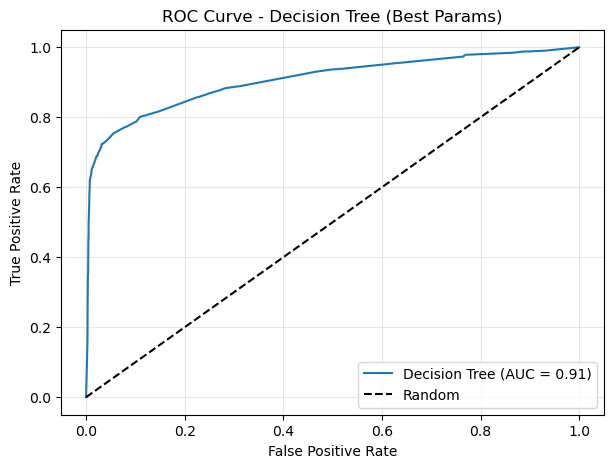

In [40]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

training_inputs, testing_inputs, training_classes, testing_classes = train_test_split(
    all_inputs, all_labels, test_size=0.25, stratify=all_labels, random_state=42
)

best_tree = grid_search.best_estimator_
best_tree.fit(training_inputs, training_classes)

y_proba = best_tree.predict_proba(testing_inputs)[:, 1]

fpr, tpr, thresholds = roc_curve(testing_classes, y_proba)
auc = roc_auc_score(testing_classes, y_proba)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'Decision Tree (AUC = {auc:.2f})')
plt.plot([0,1], [0,1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree (Best Params)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


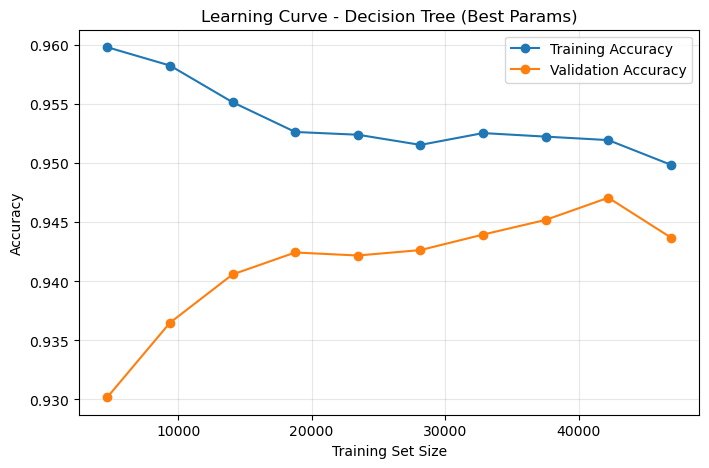

In [41]:
from sklearn.model_selection import learning_curve

best_tree = grid_search.best_estimator_

train_sizes, train_scores, val_scores = learning_curve(
    best_tree,
    all_inputs, all_labels,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, 'o-', label='Training Accuracy')
plt.plot(train_sizes, val_mean, 'o-', label='Validation Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve - Decision Tree (Best Params)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ----------------------------------------------------------------------
#### k-Nearest Neighbors (k-NN)

In [31]:
# IMPORTS
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

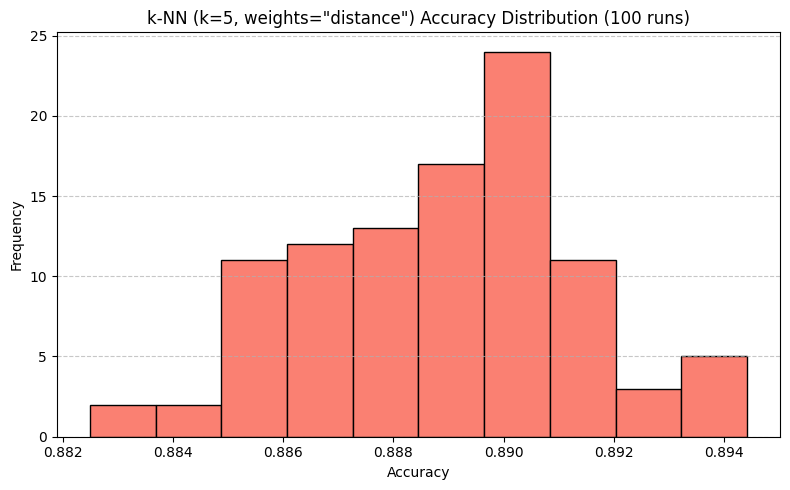

Average Accuracy over 100 runs: 0.8889


In [32]:
k = 5
weights = 'distance'

model_accuracies = []

for repetition in range(100):
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.25)
    
    knn_classifier = KNeighborsClassifier(n_neighbors=k, weights=weights)
    knn_classifier.fit(training_inputs, training_classes)
    predicted_classes = knn_classifier.predict(testing_inputs)

    model_accuracies.append(accuracy_score(testing_classes, predicted_classes))

plt.figure(figsize=(8, 5))
plt.hist(model_accuracies, bins=10, color='salmon', edgecolor='black')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title(f'k-NN (k={k}, weights="{weights}") Accuracy Distribution (100 runs)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f'Average Accuracy over 100 runs: {sum(model_accuracies) / len(model_accuracies):.4f}')


Normalized the input data and applied stratified sampling

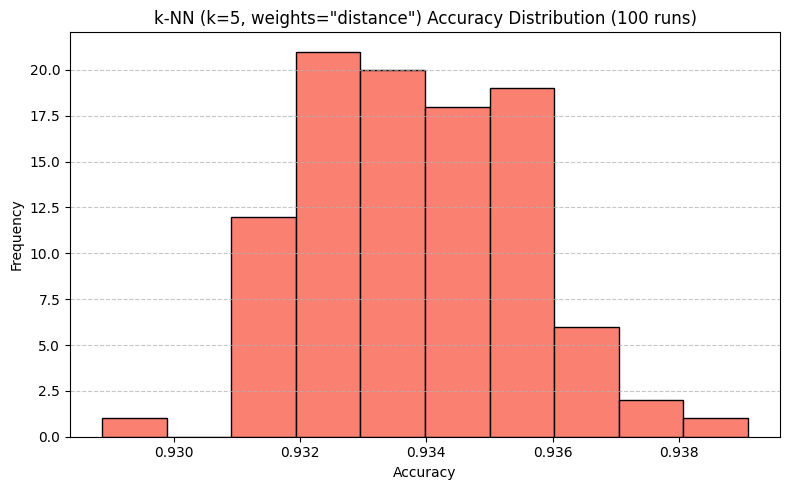

Average Accuracy over 100 runs (updated): 0.9338


In [33]:
k = 5
weights = 'distance'

model_accuracies = []

for repetition in range(100):
    # Split the dataset into training and testing sets (with stratification for balanced classes)
    training_inputs, testing_inputs, training_classes, testing_classes = train_test_split(
        all_inputs, all_labels, test_size=0.25, stratify=all_labels, random_state=repetition
    )

    # Normalize the data -> important for models with distance
    scaler = StandardScaler()
    training_inputs_scaled = scaler.fit_transform(training_inputs)
    testing_inputs_scaled = scaler.transform(testing_inputs)

    # Model k-NN Neighbor
    knn_classifier = KNeighborsClassifier(n_neighbors=k, weights=weights)
    knn_classifier.fit(training_inputs_scaled, training_classes)
    predicted_classes = knn_classifier.predict(testing_inputs_scaled)

    model_accuracies.append(accuracy_score(testing_classes, predicted_classes))

# Results
plt.figure(figsize=(8, 5))
plt.hist(model_accuracies, bins=10, color='salmon', edgecolor='black')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title(f'k-NN (k={k}, weights="{weights}") Accuracy Distribution (100 runs)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f'Average Accuracy over 100 runs (updated): {sum(model_accuracies) / len(model_accuracies):.4f}')


Trying to find the best k value 

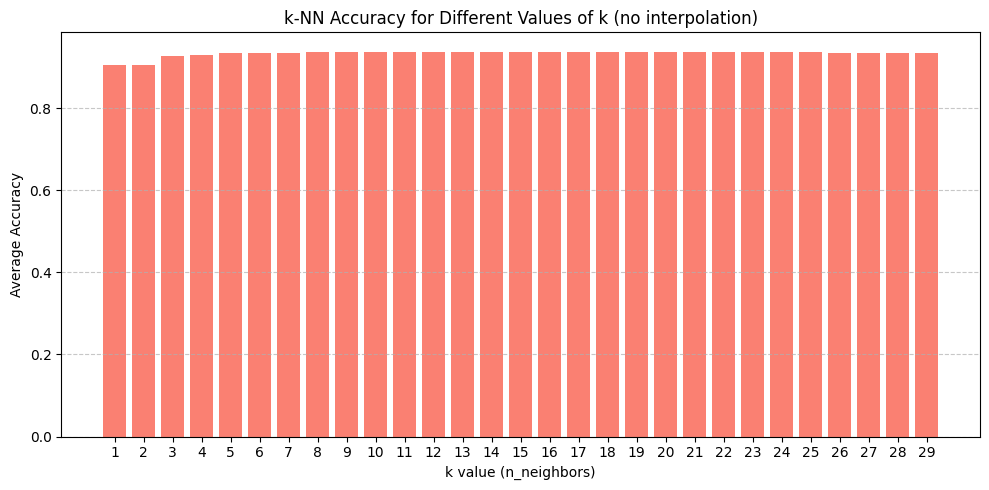

In [34]:
accuracies_by_k = {}

# Testing different values of k
for k in range(1, 30):
    model_accuracies = []
    
    for _ in range(2):
        # Split the dataset into training and testing sets (with stratification for balanced classes)
        training_inputs, testing_inputs, training_classes, testing_classes = train_test_split(
            all_inputs, all_labels, test_size=0.25, stratify=all_labels, random_state=repetition
        )
        
        # Normalize the data
        scaler = StandardScaler()
        training_inputs_scaled = scaler.fit_transform(training_inputs)
        testing_inputs_scaled = scaler.transform(testing_inputs)

        # Model k-NN Neighbor
        knn_classifier = KNeighborsClassifier(n_neighbors=k, weights=weights)
        knn_classifier.fit(training_inputs_scaled, training_classes)
        predicted_classes = knn_classifier.predict(testing_inputs_scaled)
        
        model_accuracies.append(accuracy_score(testing_classes, predicted_classes))
    
    # Average of accuracies for the current k
    accuracies_by_k[k] = sum(model_accuracies) / len(model_accuracies)

# Results
plt.figure(figsize=(10, 5))
plt.bar(accuracies_by_k.keys(), accuracies_by_k.values(), color='salmon')
plt.xlabel('k value (n_neighbors)')
plt.ylabel('Average Accuracy')
plt.title('k-NN Accuracy for Different Values of k (no interpolation)')
plt.xticks(list(accuracies_by_k.keys()))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


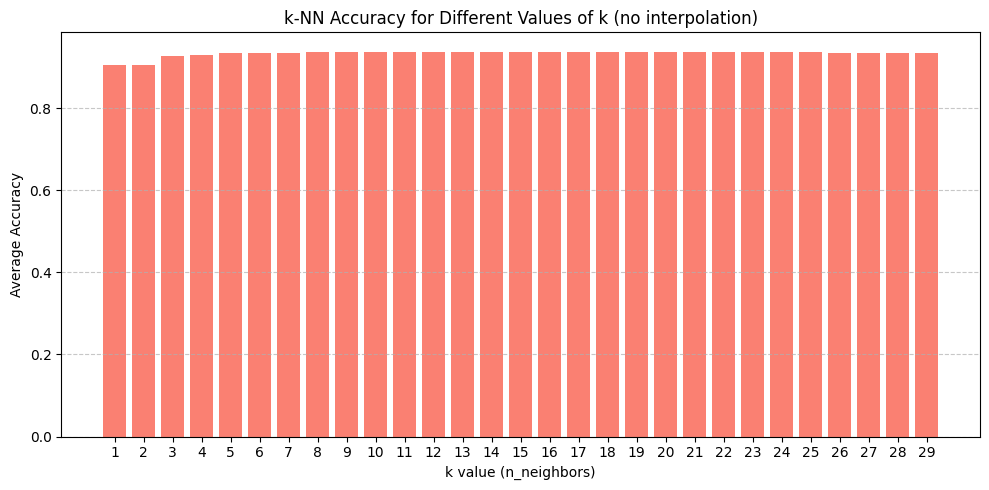

In [35]:
accuracies_by_k = {}

# Testing different values of k
for k in range(1, 30):
    model_accuracies = []
    
    for _ in range(2):
        # Split the dataset into training and testing sets (with stratification for balanced classes)
        training_inputs, testing_inputs, training_classes, testing_classes = train_test_split(
            all_inputs, all_labels, test_size=0.25, stratify=all_labels, random_state=repetition
        )
        
        # Normalize the data
        scaler = StandardScaler()
        training_inputs_scaled = scaler.fit_transform(training_inputs)
        testing_inputs_scaled = scaler.transform(testing_inputs)

        # Model k-NN Neighbor
        knn_classifier = KNeighborsClassifier(n_neighbors=k, weights=weights)
        knn_classifier.fit(training_inputs_scaled, training_classes)
        predicted_classes = knn_classifier.predict(testing_inputs_scaled)
        
        model_accuracies.append(accuracy_score(testing_classes, predicted_classes))
    
    # Average of accuracies for the current k
    accuracies_by_k[k] = sum(model_accuracies) / len(model_accuracies)

# Results
plt.figure(figsize=(10, 5))
plt.bar(accuracies_by_k.keys(), accuracies_by_k.values(), color='salmon')
plt.xlabel('k value (n_neighbors)')
plt.ylabel('Average Accuracy')
plt.title('k-NN Accuracy for Different Values of k (no interpolation)')
plt.xticks(list(accuracies_by_k.keys()))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Find best performing parameters

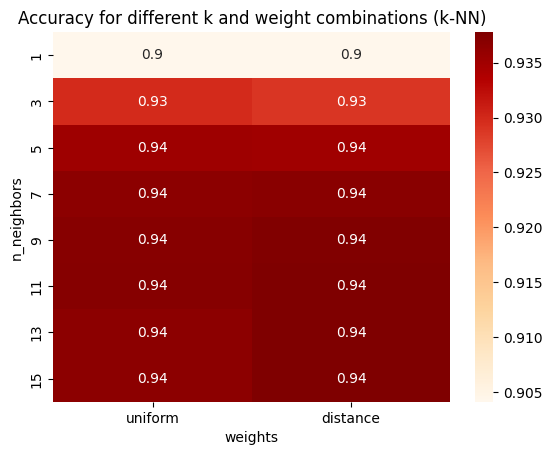

Best score: 0.9378
Best parameters: {'n_neighbors': 11, 'weights': 'distance'}


In [36]:
# Normalize the data
scaler = StandardScaler()
all_inputs_scaled = scaler.fit_transform(all_inputs)

# Sets a KNN classifier with stratified cross-validation and a parameter search for optimal values
knn_classifier = KNeighborsClassifier()
parameter_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance']
}
cross_validation = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# Grid Search
grid_search = GridSearchCV(
    estimator=knn_classifier,
    param_grid=parameter_grid,
    cv=cross_validation,
    scoring='accuracy'
)

# Adjusting model
grid_search.fit(all_inputs_scaled, all_labels)

scores = grid_search.cv_results_['mean_test_score']
grid_visualization = np.array(scores).reshape(len(parameter_grid['n_neighbors']), len(parameter_grid['weights']))

# Results
sb.heatmap(grid_visualization, cmap='OrRd', annot=True, xticklabels=parameter_grid['weights'], yticklabels=parameter_grid['n_neighbors'])
plt.xlabel('weights')
plt.ylabel('n_neighbors')
plt.title('Accuracy for different k and weight combinations (k-NN)')
plt.show()

print('Best score: {:.4f}'.format(grid_search.best_score_))
print('Best parameters:', grid_search.best_params_)


# ----------------------------------------------------------------------
#### Neural Networks (NN)

In [1]:
# IMPORTS
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [ ]:
# Neural Network Class
class NeuralNetwork:
    def __init__(self, input_shape):
        self.model = self.build_model(input_shape)

    def build_model(self, input_shape):
        model = keras.Sequential()
        model.add(layers.Dense(64, activation='relu', input_shape=(input_shape,)))
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dense(1, activation='sigmoid'))  
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

    def train(self, X_train, y_train, epochs=50, batch_size=16):
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype("int32")

    def evaluate(self, X_test, y_test):
        loss, accuracy = self.model.evaluate(X_test, y_test, verbose=0)
        return accuracy

In [ ]:
# Neural Network Training and Evaluation
data = pd.read_csv('train.csv')
data = pd.get_dummies(data, columns=["person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"])
X = data.drop(columns=['loan_status', 'id']).values
y = data['loan_status'].values

# Spliting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Normalizing the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initializing and training the neural network
nn = NeuralNetwork(input_shape=X_train.shape[1])
nn.train(X_train, y_train, epochs=50, batch_size=16)

# Evaluating the model
accuracy = nn.evaluate(X_test, y_test)
print(f'Neural Network Accuracy: {accuracy:.4f}')

c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9163 - loss: 0.2458
Epoch 2/50
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9403 - loss: 0.1922
Epoch 3/50
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9400 - loss: 0.1911
Epoch 4/50
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9427 - loss: 0.1844
Epoch 5/50
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9436 - loss: 0.1836
Epoch 6/50
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9459 - loss: 0.1771
Epoch 7/50
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9458 - loss: 0.1768
Epoch 8/50
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9463 - loss: 0.1735
Epoch 9/50
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9479 - loss: 0.1738
Epoch 10/50
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.9475 - loss: 0.1730
Epoch 11/50
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9461 - loss: 0.1750
Epoch 12/50
2749/27

Accuracy Distribution

Epoch 1/30


c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2749/2749 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9026 - loss: 0.2595
Epoch 2/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9398 - loss: 0.1887
Epoch 3/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.9403 - loss: 0.1906
Epoch 4/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - accuracy: 0.9434 - loss: 0.1825
Epoch 5/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - accuracy: 0.9455 - loss: 0.1759
Epoch 6/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9441 - loss: 0.1811
Epoch 7/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9460 - loss: 0.1769
Epoch 8/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - accuracy: 0.9451 - loss: 0.1764
Epoch 9/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 45s 12ms/step - accuracy: 0.9447 - loss: 0.1786
Epoch 10/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 37s 11ms/step - accuracy: 0.9478 - loss: 0.1718
Epoch 11/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - accuracy: 0.9473 - loss: 0.1703
Epoch 12/30
2749/2749 ━━━━

c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 35s 11ms/step - accuracy: 0.9102 - loss: 0.2523
Epoch 2/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.9381 - loss: 0.1943
Epoch 3/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9393 - loss: 0.1920
Epoch 4/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9426 - loss: 0.1832
Epoch 5/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - accuracy: 0.9427 - loss: 0.1842
Epoch 6/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9446 - loss: 0.1770
Epoch 7/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9432 - loss: 0.1807
Epoch 8/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9426 - loss: 0.1804
Epoch 9/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9451 - loss: 0.1769
Epoch 10/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9469 - loss: 0.1706
Epoch 11/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9484 - loss: 0.1696
Epoch 12/30
2749/

c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9024 - loss: 0.2585
Epoch 2/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9387 - loss: 0.1905
Epoch 3/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9416 - loss: 0.1829
Epoch 4/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9431 - loss: 0.1832
Epoch 5/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.9453 - loss: 0.1793
Epoch 6/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9440 - loss: 0.1784
Epoch 7/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9440 - loss: 0.1806
Epoch 8/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9457 - loss: 0.1752
Epoch 9/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.9472 - loss: 0.1721
Epoch 10/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9461 - loss: 0.1730
Epoch 11/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9487 - loss: 0.1707
Epoch 12/30
2749/27

c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.9165 - loss: 0.2465
Epoch 2/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.9384 - loss: 0.1895
Epoch 3/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9418 - loss: 0.1841
Epoch 4/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9426 - loss: 0.1835
Epoch 5/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9444 - loss: 0.1796
Epoch 6/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9450 - loss: 0.1785
Epoch 7/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9460 - loss: 0.1756
Epoch 8/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9458 - loss: 0.1798
Epoch 9/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9451 - loss: 0.1760
Epoch 10/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9494 - loss: 0.1683
Epoch 11/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.9465 - loss: 0.1746
Epoch 12/30
2749/27

c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - accuracy: 0.9149 - loss: 0.2487
Epoch 2/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9392 - loss: 0.1893
Epoch 3/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9421 - loss: 0.1834
Epoch 4/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - accuracy: 0.9440 - loss: 0.1787
Epoch 5/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.9438 - loss: 0.1810
Epoch 6/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9468 - loss: 0.1745
Epoch 7/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - accuracy: 0.9468 - loss: 0.1730
Epoch 8/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - accuracy: 0.9455 - loss: 0.1784
Epoch 9/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - accuracy: 0.9463 - loss: 0.1735
Epoch 10/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 0.9446 - loss: 0.1763
Epoch 11/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9487 - loss: 0.1706
Epoch 12/30
2749/27

c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9112 - loss: 0.2527
Epoch 2/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9394 - loss: 0.1929
Epoch 3/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9415 - loss: 0.1889
Epoch 4/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9443 - loss: 0.1845
Epoch 5/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9440 - loss: 0.1818
Epoch 6/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9470 - loss: 0.1783
Epoch 7/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9458 - loss: 0.1759
Epoch 8/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9466 - loss: 0.1777
Epoch 9/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9465 - loss: 0.1755
Epoch 10/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9481 - loss: 0.1696
Epoch 11/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9486 - loss: 0.1679
Epoch 12/30
2749/2749 ━━━━━━━━━━━━━━━━━━━

c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2749/2749 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9083 - loss: 0.2613
Epoch 2/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9387 - loss: 0.1962
Epoch 3/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9415 - loss: 0.1857
Epoch 4/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9424 - loss: 0.1861
Epoch 5/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9422 - loss: 0.1875
Epoch 6/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9436 - loss: 0.1831
Epoch 7/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9424 - loss: 0.1847
Epoch 8/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9435 - loss: 0.1829
Epoch 9/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9453 - loss: 0.1776
Epoch 10/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9447 - loss: 0.1774
Epoch 11/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9432 - loss: 0.1830
Epoch 12/30
2749/2749 ━━━━━━━━━━━━━━━━━━━

c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2749/2749 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9089 - loss: 0.2530
Epoch 2/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9399 - loss: 0.1917
Epoch 3/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9397 - loss: 0.1860
Epoch 4/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9410 - loss: 0.1852
Epoch 5/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9430 - loss: 0.1835
Epoch 6/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9437 - loss: 0.1836
Epoch 7/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9458 - loss: 0.1752
Epoch 8/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9439 - loss: 0.1802
Epoch 9/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9443 - loss: 0.1807
Epoch 10/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9473 - loss: 0.1725
Epoch 11/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9479 - loss: 0.1711
Epoch 12/30
2749/2749 ━━━━━━━━━━━━━━━━━━━

c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2749/2749 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9122 - loss: 0.2522
Epoch 2/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9385 - loss: 0.1931
Epoch 3/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9426 - loss: 0.1852
Epoch 4/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9447 - loss: 0.1800
Epoch 5/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9453 - loss: 0.1767
Epoch 6/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9449 - loss: 0.1737
Epoch 7/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9457 - loss: 0.1765
Epoch 8/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9451 - loss: 0.1766
Epoch 9/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9461 - loss: 0.1751
Epoch 10/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9457 - loss: 0.1756
Epoch 11/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9452 - loss: 0.1766
Epoch 12/30
2749/2749 ━━━━━━━━━━━━━━━━━━━

c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9133 - loss: 0.2478
Epoch 2/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9390 - loss: 0.1924
Epoch 3/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9411 - loss: 0.1870
Epoch 4/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9424 - loss: 0.1842
Epoch 5/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9459 - loss: 0.1787
Epoch 6/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9453 - loss: 0.1776
Epoch 7/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9455 - loss: 0.1769
Epoch 8/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9463 - loss: 0.1747
Epoch 9/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9453 - loss: 0.1766
Epoch 10/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9493 - loss: 0.1671
Epoch 11/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9486 - loss: 0.1688
Epoch 12/30
2749/2749 ━━━━━━━━━━━━━━━━━━━

c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2749/2749 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9095 - loss: 0.2527
Epoch 2/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9375 - loss: 0.1936
Epoch 3/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9398 - loss: 0.1891
Epoch 4/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9416 - loss: 0.1872
Epoch 5/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9445 - loss: 0.1774
Epoch 6/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9443 - loss: 0.1776
Epoch 7/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9457 - loss: 0.1742
Epoch 8/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9460 - loss: 0.1765
Epoch 9/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9473 - loss: 0.1736
Epoch 10/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9482 - loss: 0.1730
Epoch 11/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9464 - loss: 0.1731
Epoch 12/30
2749/2749 ━━━━━━━━━━━━━━━━━━━

c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2749/2749 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8858 - loss: 0.2792
Epoch 2/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9366 - loss: 0.1917
Epoch 3/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9407 - loss: 0.1877
Epoch 4/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9431 - loss: 0.1840
Epoch 5/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9440 - loss: 0.1853
Epoch 6/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9455 - loss: 0.1774
Epoch 7/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9425 - loss: 0.1826
Epoch 8/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9447 - loss: 0.1743
Epoch 9/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9465 - loss: 0.1770
Epoch 10/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9449 - loss: 0.1794
Epoch 11/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9479 - loss: 0.1725
Epoch 12/30
2749/2749 ━━━━━━━━━━━━━━━━━━━

c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2749/2749 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8962 - loss: 0.2649
Epoch 2/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9370 - loss: 0.1930
Epoch 3/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9421 - loss: 0.1856
Epoch 4/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9428 - loss: 0.1827
Epoch 5/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9443 - loss: 0.1804
Epoch 6/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9436 - loss: 0.1800
Epoch 7/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9454 - loss: 0.1766
Epoch 8/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9460 - loss: 0.1730
Epoch 9/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9444 - loss: 0.1773
Epoch 10/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9474 - loss: 0.1720
Epoch 11/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9480 - loss: 0.1702
Epoch 12/30
2749/2749 ━━━━━━━━━━━━━━━━━━━

c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2749/2749 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9097 - loss: 0.2513
Epoch 2/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9397 - loss: 0.1912
Epoch 3/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9420 - loss: 0.1856
Epoch 4/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9438 - loss: 0.1808
Epoch 5/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9437 - loss: 0.1826
Epoch 6/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9452 - loss: 0.1770
Epoch 7/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9467 - loss: 0.1752
Epoch 8/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9468 - loss: 0.1730
Epoch 9/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9475 - loss: 0.1715
Epoch 10/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9472 - loss: 0.1710
Epoch 11/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9481 - loss: 0.1702
Epoch 12/30
2749/2749 ━━━━━━━━━━━━━━━━━━━

c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2749/2749 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9104 - loss: 0.2476
Epoch 2/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9371 - loss: 0.1923
Epoch 3/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9414 - loss: 0.1852
Epoch 4/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9439 - loss: 0.1821
Epoch 5/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9427 - loss: 0.1855
Epoch 6/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9446 - loss: 0.1792
Epoch 7/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9444 - loss: 0.1781
Epoch 8/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9445 - loss: 0.1784
Epoch 9/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9469 - loss: 0.1736
Epoch 10/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9472 - loss: 0.1731
Epoch 11/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9475 - loss: 0.1746
Epoch 12/30
2749/2749 ━━━━━━━━━━━━━━━━━━━

c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2749/2749 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9098 - loss: 0.2555
Epoch 2/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9397 - loss: 0.1918
Epoch 3/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9397 - loss: 0.1874
Epoch 4/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9445 - loss: 0.1788
Epoch 5/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9449 - loss: 0.1777
Epoch 6/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9468 - loss: 0.1748
Epoch 7/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9456 - loss: 0.1730
Epoch 8/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9456 - loss: 0.1740
Epoch 9/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9472 - loss: 0.1724
Epoch 10/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9460 - loss: 0.1729
Epoch 11/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9487 - loss: 0.1711
Epoch 12/30
2749/2749 ━━━━━━━━━━━━━━━━━━━

c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2749/2749 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9055 - loss: 0.2594
Epoch 2/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9385 - loss: 0.1893
Epoch 3/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9402 - loss: 0.1877
Epoch 4/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9428 - loss: 0.1824
Epoch 5/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9433 - loss: 0.1812
Epoch 6/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9459 - loss: 0.1747
Epoch 7/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9439 - loss: 0.1795
Epoch 8/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9465 - loss: 0.1747
Epoch 9/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9458 - loss: 0.1735
Epoch 10/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9464 - loss: 0.1745
Epoch 11/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9485 - loss: 0.1661
Epoch 12/30
2749/2749 ━━━━━━━━━━━━━━━━━━━

c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9101 - loss: 0.2513
Epoch 2/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9399 - loss: 0.1893
Epoch 3/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9433 - loss: 0.1807
Epoch 4/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9445 - loss: 0.1787
Epoch 5/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9447 - loss: 0.1773
Epoch 6/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9447 - loss: 0.1822
Epoch 7/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9455 - loss: 0.1757
Epoch 8/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9462 - loss: 0.1765
Epoch 9/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9472 - loss: 0.1714
Epoch 10/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9463 - loss: 0.1743
Epoch 11/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9477 - loss: 0.1695
Epoch 12/30
2749/2749 ━━━━━━━━━━━━━━━━━━━

c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9137 - loss: 0.2489
Epoch 2/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9376 - loss: 0.1947
Epoch 3/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9401 - loss: 0.1897
Epoch 4/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9425 - loss: 0.1842
Epoch 5/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9426 - loss: 0.1831
Epoch 6/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9440 - loss: 0.1824
Epoch 7/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9437 - loss: 0.1814
Epoch 8/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9451 - loss: 0.1771
Epoch 9/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9481 - loss: 0.1718
Epoch 10/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9459 - loss: 0.1758
Epoch 11/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9442 - loss: 0.1792
Epoch 12/30
2749/2749 ━━━━━━━━━━━━━━━━━━━

c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9050 - loss: 0.2535
Epoch 2/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9380 - loss: 0.1930
Epoch 3/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9395 - loss: 0.1898
Epoch 4/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9434 - loss: 0.1799
Epoch 5/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9443 - loss: 0.1797
Epoch 6/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9440 - loss: 0.1780
Epoch 7/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9450 - loss: 0.1779
Epoch 8/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9474 - loss: 0.1756
Epoch 9/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9461 - loss: 0.1762
Epoch 10/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9472 - loss: 0.1740
Epoch 11/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9470 - loss: 0.1724
Epoch 12/30
2749/2749 ━━━━━━━━━━━━━━━━━━━

c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2749/2749 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9115 - loss: 0.2468
Epoch 2/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9386 - loss: 0.1946
Epoch 3/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9424 - loss: 0.1846
Epoch 4/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9435 - loss: 0.1821
Epoch 5/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9457 - loss: 0.1773
Epoch 6/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9462 - loss: 0.1785
Epoch 7/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9441 - loss: 0.1796
Epoch 8/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9459 - loss: 0.1737
Epoch 9/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9466 - loss: 0.1756
Epoch 10/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9480 - loss: 0.1704
Epoch 11/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9470 - loss: 0.1709
Epoch 12/30
2749/2749 ━━━━━━━━━━━━━━━━━━━

c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2749/2749 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8998 - loss: 0.2621
Epoch 2/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9387 - loss: 0.1950
Epoch 3/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9430 - loss: 0.1827
Epoch 4/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9424 - loss: 0.1839
Epoch 5/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9424 - loss: 0.1845
Epoch 6/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9432 - loss: 0.1838
Epoch 7/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9432 - loss: 0.1814
Epoch 8/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9458 - loss: 0.1765
Epoch 9/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9446 - loss: 0.1801
Epoch 10/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9487 - loss: 0.1719
Epoch 11/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9457 - loss: 0.1765
Epoch 12/30
2749/2749 ━━━━━━━━━━━━━━━━━━━

c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2749/2749 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9071 - loss: 0.2540
Epoch 2/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9397 - loss: 0.1909
Epoch 3/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9419 - loss: 0.1835
Epoch 4/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9406 - loss: 0.1896
Epoch 5/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9443 - loss: 0.1763
Epoch 6/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9444 - loss: 0.1815
Epoch 7/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9457 - loss: 0.1753
Epoch 8/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 127s 46ms/step - accuracy: 0.9447 - loss: 0.1756
Epoch 9/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 1360s 495ms/step - accuracy: 0.9478 - loss: 0.1729
Epoch 10/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9462 - loss: 0.1760
Epoch 11/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9446 - loss: 0.1772
Epoch 12/30
2749/2749 ━━━━━━━━━━

c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2749/2749 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9113 - loss: 0.2522
Epoch 2/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9416 - loss: 0.1871
Epoch 3/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9429 - loss: 0.1851
Epoch 4/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9432 - loss: 0.1852
Epoch 5/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9441 - loss: 0.1802
Epoch 6/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9467 - loss: 0.1750
Epoch 7/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9449 - loss: 0.1785
Epoch 8/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9483 - loss: 0.1714
Epoch 9/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9471 - loss: 0.1723
Epoch 10/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9473 - loss: 0.1693
Epoch 11/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9469 - loss: 0.1714
Epoch 12/30
2749/2749 ━━━━━━━━━━━━

c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2749/2749 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9104 - loss: 0.2546
Epoch 2/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9364 - loss: 0.1962
Epoch 3/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9416 - loss: 0.1860
Epoch 4/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9415 - loss: 0.1858
Epoch 5/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9435 - loss: 0.1818
Epoch 6/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9458 - loss: 0.1750
Epoch 7/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9452 - loss: 0.1791
Epoch 8/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9462 - loss: 0.1761
Epoch 9/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9466 - loss: 0.1738
Epoch 10/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9467 - loss: 0.1728
Epoch 11/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9477 - loss: 0.1698
Epoch 12/30
2749/2749 ━━━━━━━━━━━━━

c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2749/2749 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9012 - loss: 0.2646
Epoch 2/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9366 - loss: 0.1968
Epoch 3/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9397 - loss: 0.1900
Epoch 4/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9425 - loss: 0.1813
Epoch 5/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9463 - loss: 0.1791
Epoch 6/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9454 - loss: 0.1801
Epoch 7/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9452 - loss: 0.1766
Epoch 8/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9453 - loss: 0.1767
Epoch 9/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9452 - loss: 0.1770
Epoch 10/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9455 - loss: 0.1768
Epoch 11/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9474 - loss: 0.1718
Epoch 12/30
2749/2749 ━━━━━━━━━━

c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8967 - loss: 0.2656
Epoch 2/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9386 - loss: 0.1900
Epoch 3/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9424 - loss: 0.1836
Epoch 4/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9452 - loss: 0.1795
Epoch 5/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9442 - loss: 0.1795
Epoch 6/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9435 - loss: 0.1796
Epoch 7/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9439 - loss: 0.1791
Epoch 8/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9469 - loss: 0.1741
Epoch 9/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9467 - loss: 0.1749
Epoch 10/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9459 - loss: 0.1726
Epoch 11/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9467 - loss: 0.1721
Epoch 12/30
2749/2749 ━━━━━━━━━━━━━━━━━━━

c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8989 - loss: 0.2645
Epoch 2/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9396 - loss: 0.1914
Epoch 3/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9417 - loss: 0.1853
Epoch 4/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9441 - loss: 0.1801
Epoch 5/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9440 - loss: 0.1817
Epoch 6/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9458 - loss: 0.1804
Epoch 7/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9444 - loss: 0.1813
Epoch 8/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9476 - loss: 0.1742
Epoch 9/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9482 - loss: 0.1703
Epoch 10/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9507 - loss: 0.1645
Epoch 11/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9498 - loss: 0.1677
Epoch 12/30
2749/2749 ━━━━━━━━━━━━━━━━━━━

c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9112 - loss: 0.2489  
Epoch 2/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3804s 1s/step - accuracy: 0.9363 - loss: 0.1950
Epoch 3/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9423 - loss: 0.1837
Epoch 4/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9421 - loss: 0.1830
Epoch 5/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9440 - loss: 0.1812
Epoch 6/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9444 - loss: 0.1781
Epoch 7/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9460 - loss: 0.1782
Epoch 8/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9458 - loss: 0.1757
Epoch 9/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9463 - loss: 0.1750
Epoch 10/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9465 - loss: 0.1728
Epoch 11/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9459 - loss: 0.1765
Epoch 12/30
2749/2749 ━━━━━━━━━━━━━━━

c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2749/2749 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8935 - loss: 0.2649
Epoch 2/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9388 - loss: 0.1935
Epoch 3/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9413 - loss: 0.1882
Epoch 4/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9447 - loss: 0.1773
Epoch 5/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9440 - loss: 0.1801
Epoch 6/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9458 - loss: 0.1788
Epoch 7/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9465 - loss: 0.1761
Epoch 8/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9445 - loss: 0.1778
Epoch 9/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9454 - loss: 0.1758
Epoch 10/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9496 - loss: 0.1681
Epoch 11/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9496 - loss: 0.1652
Epoch 12/30
2749/2749 ━━━━━━━━━━━━━━━━━━━

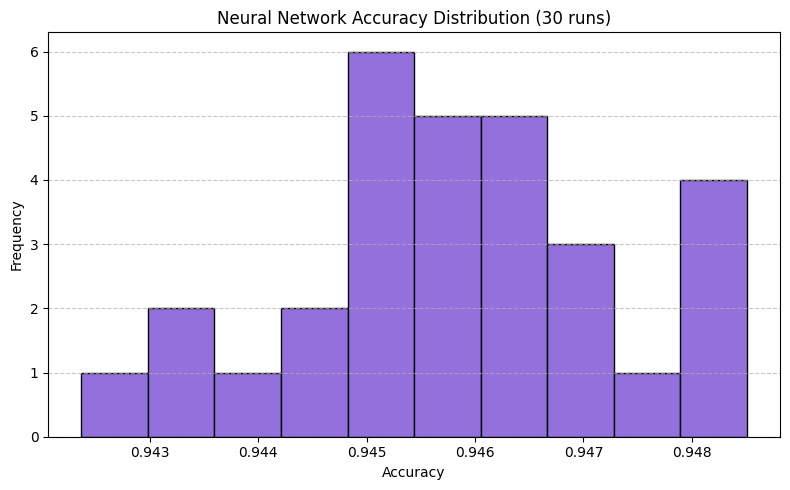

Average Neural Network Accuracy over 30 runs: 0.9458


In [ ]:
# Neural Network: Accuracy Distribution over Multiple Runs
nn_accuracies = []
num_runs = 30 

for repetition in range(num_runs):
    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, stratify=y, random_state=repetition
    )
    # Normalizing the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    # Training NN
    nn = NeuralNetwork(input_shape=X_train.shape[1])
    nn.train(X_train_scaled, y_train, epochs=30, batch_size=16) 
    # Evaluating NN
    acc = nn.evaluate(X_test_scaled, y_test)
    nn_accuracies.append(acc)

# Plot accuracy distribution
plt.figure(figsize=(8, 5))
plt.hist(nn_accuracies, bins=10, color='mediumpurple', edgecolor='black')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title(f'Neural Network Accuracy Distribution ({num_runs} runs)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f'Average Neural Network Accuracy over {num_runs} runs: {np.mean(nn_accuracies):.4f}')

Standard Deviation


In [8]:
std_dev = np.std(nn_accuracies)
print(f'Standard Deviation: {std_dev:.4f}')


Standard Deviation: 0.0015


Minimum/ Maximum Accuracy

In [ ]:
min_acc = np.min(nn_accuracies)
max_acc = np.max(nn_accuracies)
print(f'Minimum Accuracy: {min_acc:.4f}')
print(f'Maximum Accuracy: {max_acc:.4f}')


Minimum Accuracy: 0.9424
Maximum Accuracy: 0.9485


Confidence Interval

In [21]:
from scipy import stats

confidence_interval = stats.t.interval(0.95, len(nn_accuracies)-1, loc=np.mean(nn_accuracies), scale=stats.sem(nn_accuracies))
lower_bound, upper_bound = confidence_interval
print(f'95% Confidence Interval: ({lower_bound:.4f}, {upper_bound:.4f})')



95% Confidence Interval: (0.9452, 0.9464)


Boxplot of Accuracy Distribution

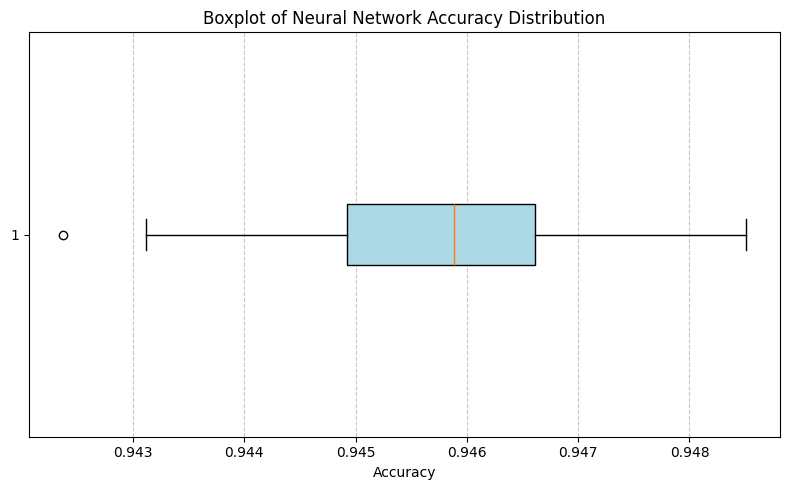

In [12]:
plt.figure(figsize=(8, 5))
plt.boxplot(nn_accuracies, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue', color='black'))
plt.title('Boxplot of Neural Network Accuracy Distribution')
plt.xlabel('Accuracy')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


C:\Users\diana\AppData\Local\Temp\ipykernel_24472\1992047977.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(nn_accuracies, shade=True, color='mediumpurple')


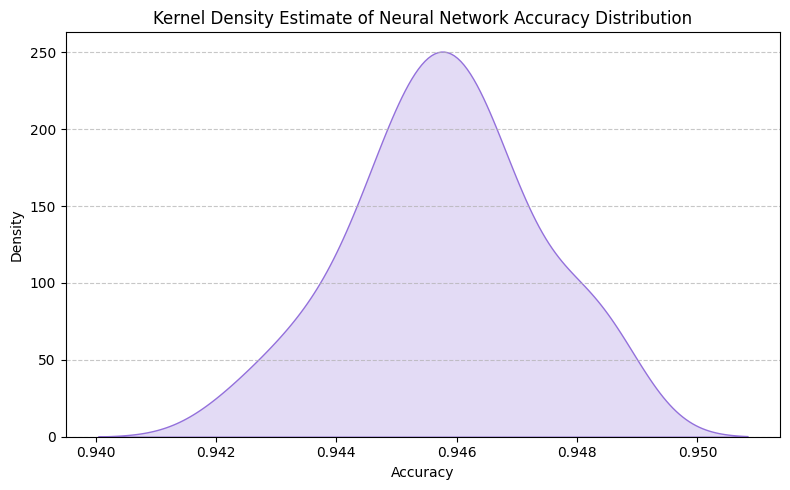

In [13]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.kdeplot(nn_accuracies, shade=True, color='mediumpurple')
plt.title('Kernel Density Estimate of Neural Network Accuracy Distribution')
plt.xlabel('Accuracy')
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
